# Star Classification


### Context
**In astronomy, stellar classification is the classification of stars based on their spectral
characteristics. The classification scheme of galaxies, quasars, and stars is one of the most
fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has
led to the understanding that they make up our own galaxy and, following the distinction that
Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as
more powerful telescopes were built. This dataset aims to classify stars, galaxies, and
quasars based on their spectral characteristics.**

### Data
**The data consists of 30,000 observations of space taken by the SDSS (Sloan Digital Sky
Survey). Every observation is described by 17 feature columns and 1 class column which
identifies it to be either a star, galaxy or quasar. Therefore, this is a multi-class classification
problem.**

**The column names and explanations are as follows:**
1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib
%matplotlib inline
from datetime import datetime, timedelta

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, RocCurveDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB   
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_selector as selector
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.multiclass import OneVsRestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import ExtraTreesClassifier

### Initial Look at Dataset

In [114]:
#Load dataset into dataframe
df = pd.read_csv("21334466.csv")

In [115]:
#Get first 5 rows of dataset
df.head(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237664e+18,114.842705,48.579641,24.14193,21.57223,20.95319,20.63342,20.58723,4264,301,5,83,4.126610e+18,STAR,-0.000352,3665,55247,678
1,1.237660e+18,52.789625,-0.708809,20.97046,20.59845,19.97687,19.86969,20.04365,3438,301,2,152,2.329547e+18,QSO,1.272514,2069,53376,217
2,1.237668e+18,131.780911,13.096127,24.89342,23.14699,21.12214,20.22904,19.80308,5194,301,2,121,5.953973e+18,GALAXY,0.521980,5288,55865,779
3,1.237658e+18,180.413180,50.984733,16.81303,15.97135,15.70821,15.60510,15.58369,2964,301,6,302,3.258447e+18,STAR,-0.001060,2894,54539,337
4,1.237666e+18,48.547125,1.118479,23.15991,22.20097,20.19419,19.34320,18.82036,4849,301,6,779,1.704778e+18,GALAXY,0.468210,1514,52931,601


In [117]:
#Get number of rows and columns
df.shape

(30000, 18)

In [118]:
#Get descriptive statistics for numerical features
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,1.237665e+18,177.916629,24.416020,21.743336,20.297381,19.643908,19.082833,18.432603,4474.105133,301.0,3.498533,186.872733,5.788730e+18,0.576217,5141.315667,55594.439033,448.353433
std,8.406784e+12,95.785957,19.628449,57.900192,57.884254,1.853814,1.756060,57.864449,1957.366317,0.0,1.588631,149.864003,3.307571e+18,0.729342,2937.697360,1797.356149,273.151821
min,1.237646e+18,0.024619,-17.363047,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.996631e+17,-0.006055,266.000000,51608.000000,1.000000
25%,1.237659e+18,128.459437,5.524232,20.353210,18.969957,18.126373,17.723340,17.448560,3187.000000,301.0,2.000000,82.000000,2.862195e+18,0.053773,2542.000000,54252.000000,218.000000
50%,1.237663e+18,181.116741,24.073909,22.178720,21.089620,20.122445,19.408790,19.008295,4192.000000,301.0,4.000000,146.000000,5.629716e+18,0.425141,5000.000000,55882.000000,432.000000
75%,1.237668e+18,233.472811,40.193356,23.676448,22.120025,21.041595,20.397130,19.919992,5323.000000,301.0,5.000000,242.000000,8.326107e+18,0.703406,7395.000000,56772.000000,644.000000
max,1.237681e+18,359.999810,83.000519,28.778120,31.602240,27.593320,32.141470,28.790550,8162.000000,301.0,6.000000,989.000000,1.412693e+19,7.011245,12547.000000,58932.000000,1000.000000


## Task 1: Prepare a data quality plan for the dataset. 

**- Mark down all the features where there are potential problems or data quality issues.**

**- Propose solutions to deal with the problems identified.**

**- Explain why you chose one solution over potentially many other.** 

**It is very important to provide justification for your thinking in this part and to list potential solutions, including the solution that will be implemented to clean the data. In particular, pay attention to missing data and carefully address this issue.**

### Check Unique Values

In [119]:
# Get the number of unique values per feature
df.nunique()

obj_ID         27501
alpha          30000
delta          30000
u              29360
g              29331
r              29242
i              29232
z              29234
run_ID           410
rerun_ID           1
cam_col            6
field_ID         821
spec_obj_ID    30000
class              3
redshift       29853
plate           5772
MJD             2131
fiber_ID        1000
dtype: int64

Many features here (alpha, delta, u, g, r, i, z, redshift, etc) are continuous features (possibly infinite set of values)

It makes sense that they have nearly 30000 values, as each row in the dataset could have a unique value for those features.

#### Problem 1: Constant Column
There is only one possible value for rerun_ID, so it is not a useful feature for classification. (i.e. its value never changes so it does not help predict the class)

Therefore, we can drop that column. There is no reason to keep it around so the only solution here is to remove it. We gain no information by keeping it.

### Check for Missing Data

In [120]:
df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

There are no missing values at all! Great start :)

### Check Feature Data Types

In [121]:
#Get data types of each column
df.dtypes

obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object

#### Problem 2: Incorrect feature data type
obj_ID is set as a continuous data type (float64), when it could be better seen as categorical. 

Similarly, we can convert run_ID, field_ID, spec_obj_ID, and fiber_ID. plate is also an id, so it will be converted as well.

cam_col and class are discrete data types (as we saw by value_counts, they have a small finite set of values), so we'll convert those to categorical as well.

### Check for Duplicates

In [122]:
df[df.duplicated]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID


No duplicates! :)

(We know there are no duplicate columns by looking at the dataframe, so we're just checking for duplicate rows here)

### Plot histograms summary sheet for all the continuous features.

Let's take a closer look at our data by plotting its distribution

In [123]:
params = {'axes.titlesize':'20',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)

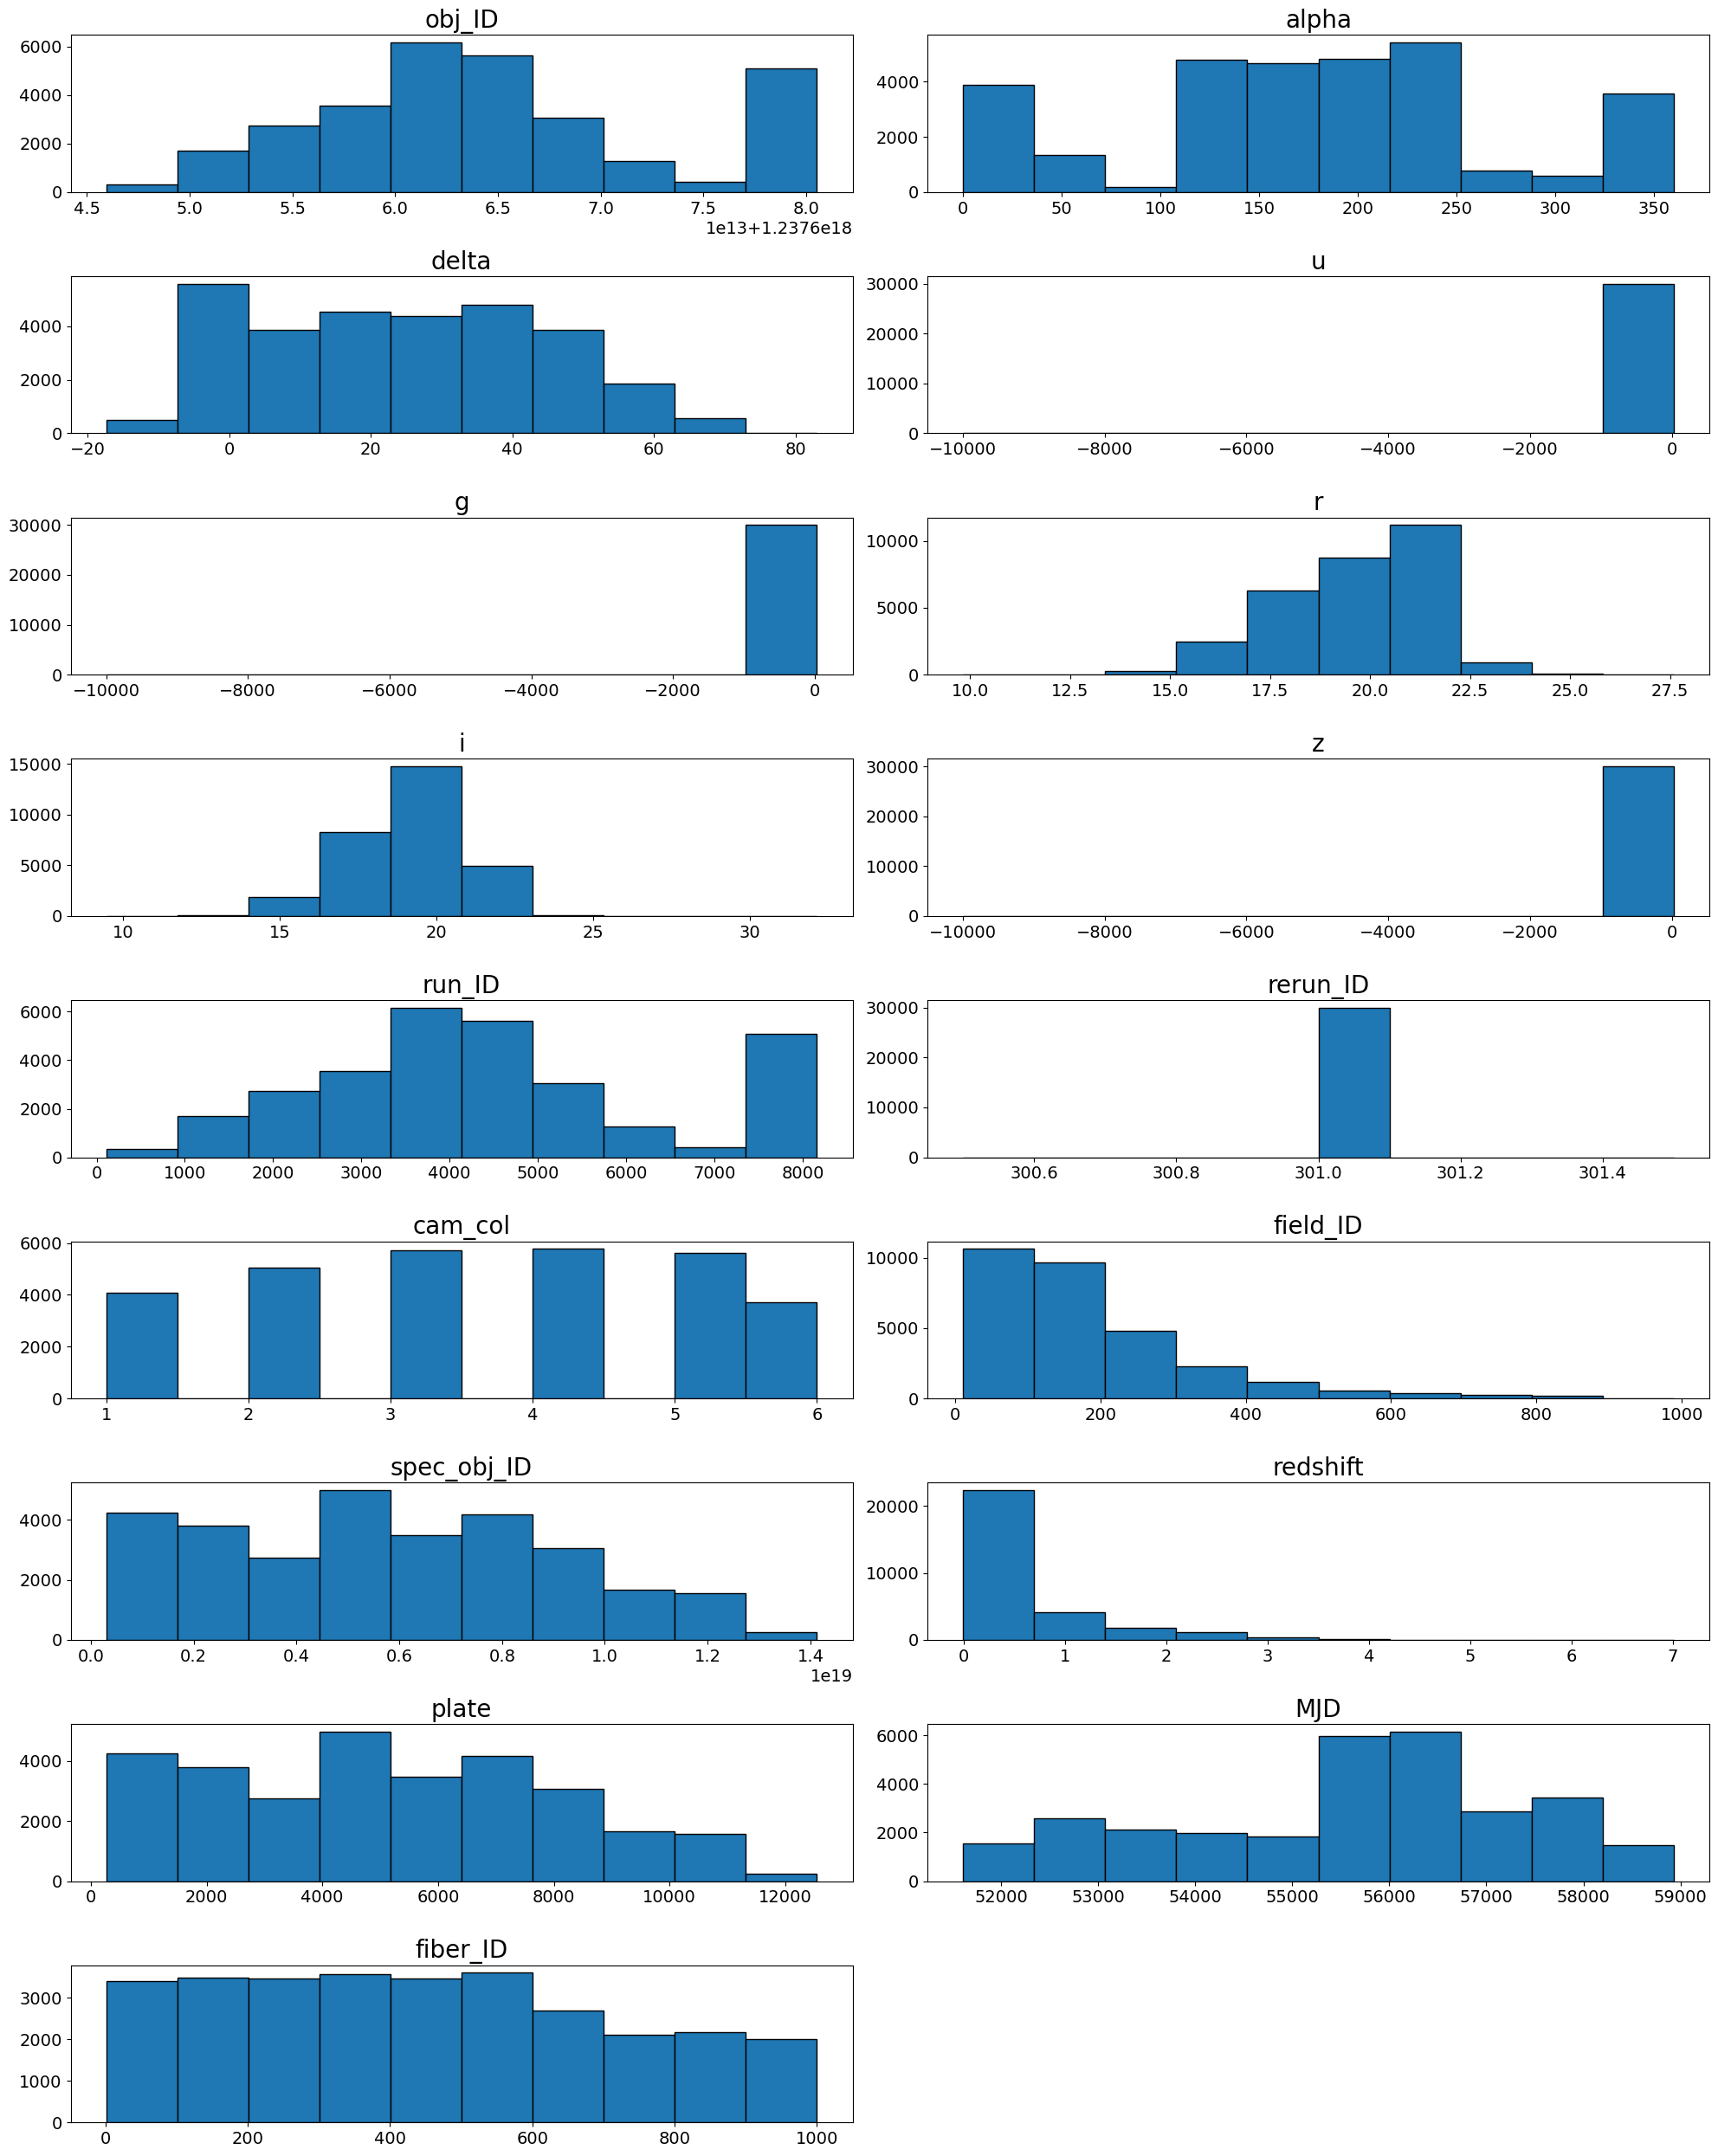

In [126]:
df.hist(figsize=(20, 25), layout=(9,2), grid=False, edgecolor="black")
plt.tight_layout()

### Plot box plots summary sheet for all the continuous features.

Boxplots will be quite useful as well - they will allow us to detect outliers and noise better.

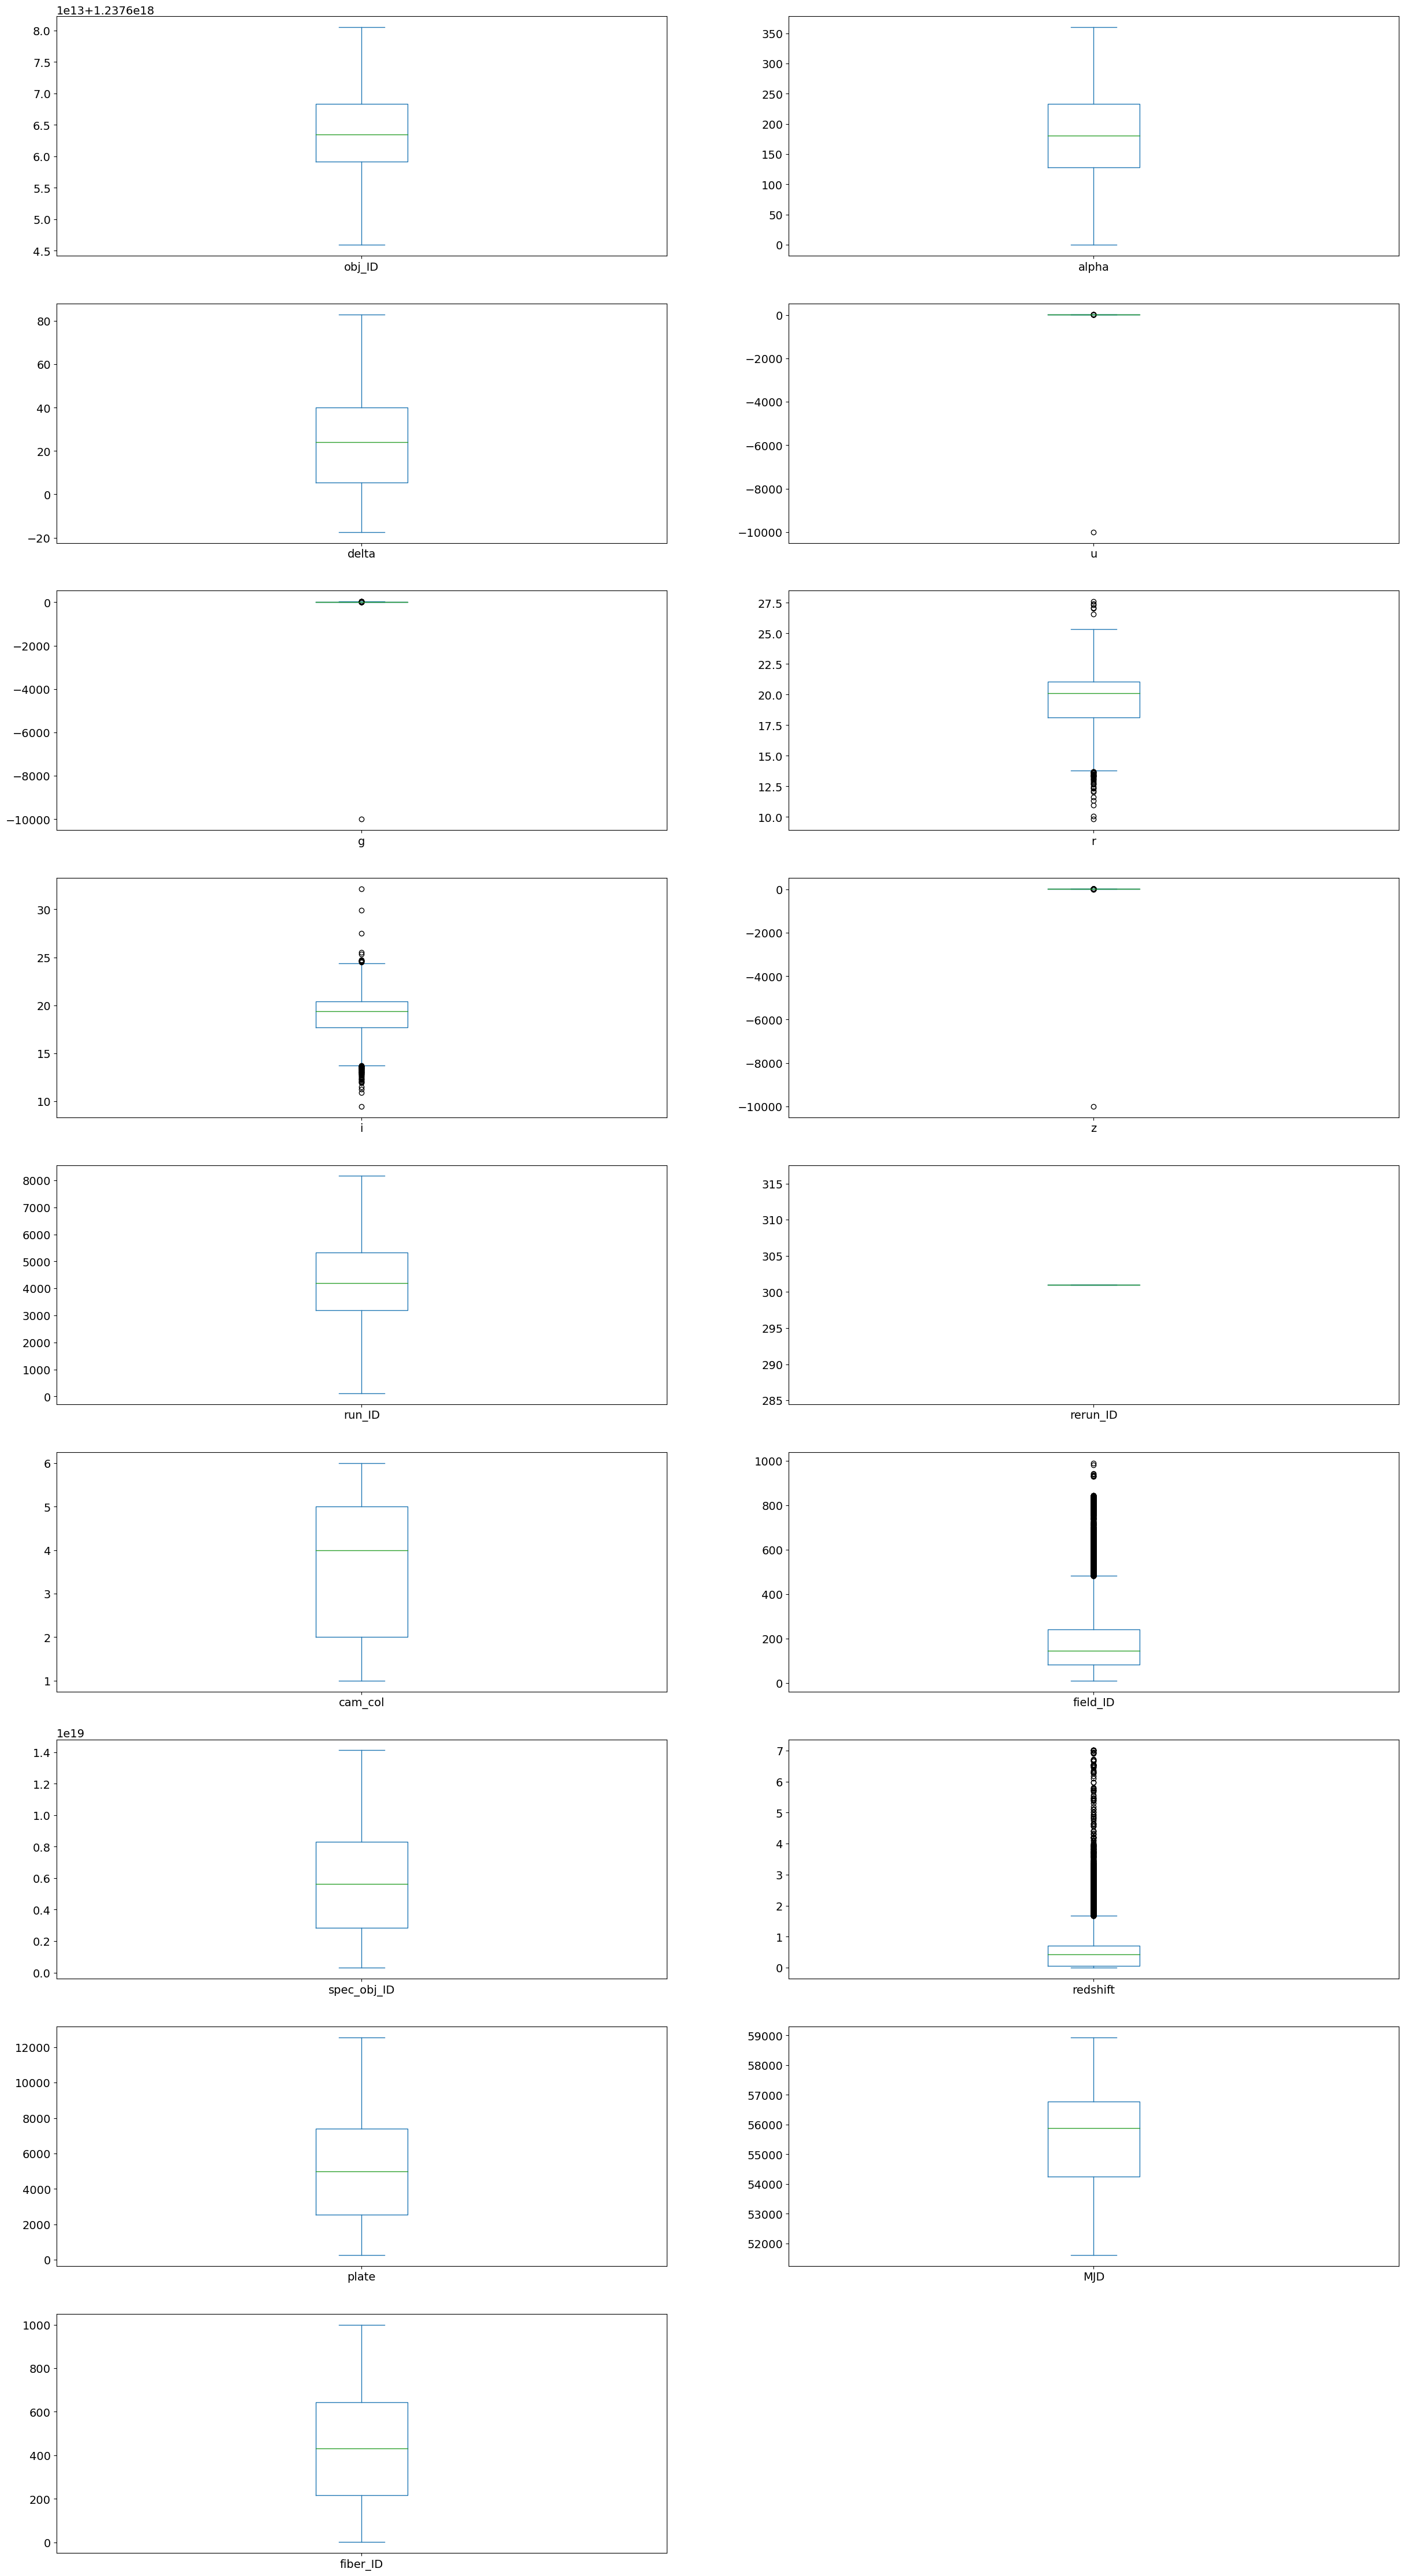

In [128]:
df.plot(kind='box', subplots=True, figsize=(30,70), layout=(11,2), sharex=False, sharey=False);

Some histograms look strange - notably "u", "g", and "z". We saw that those features had many unique values, so it doesn't make sense that there is only one bin in their histograms. 

The same issue is showing up in the boxplots. "u", "g", and "z" have extreme outliers. 

Let's investigate further:

### Problem 3 - Outlier in "u" feature

Based on the boxplot, we can see that there is a value very far off from the usual range. Let's check the descriptive statistics of "u" to find out its value in comparison to most values.

In [129]:
df['u'].describe()

count    30000.000000
mean        21.743336
std         57.900192
min      -9999.000000
25%         20.353210
50%         22.178720
75%         23.676448
max         28.778120
Name: u, dtype: float64

It looks like most values in "u" are in the range 20-28, but the minimum value is way off, at -9999. 

Since it is not remotely close to the range of real values, I would classify it as a mistake rather than an odd case of extreme outliers.

There are a couple of ways to handle such outliers:
1) Delete row with erroneous value
2) Replace erroneous value with a constant 0
3) Replace erroneous value with a constant mean
4) Replace erroneous value with a constant median

In [130]:
#Check how many outliers there are
df[df['u'] < 0]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
2809,1.237649e+18,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,301,2,537,3.731277e+18,STAR,0.000089,3314,54970,162


There is only one row with an extreme value.

Since it is just one mistake, and not several rows with errors, then the solution we use to get rid of the error won't significantly affect our results later on.

This means that we can choose any of the solutions above. I will go with a solution that replaces the error with a constant so that we can still keep the information about the other features for that row. While one row is not significant, the other information (features) that the row has could be useful for classification later on. 

I will choose the median as a constant, instead of 0, as it is likely to be closer to the actual "u" value of the object in that row. I picked the median over the mean because it is less sensitive to outliers (on the offchance that there are still outliers, even without the erroneous value)

Note - it's also possible to do a forward fill or a backward fill, but that is more suitable for time series data. 

### Problem 4 - Outlier in "g" feature

Let's look at another feature with a similar problem to the previous one.

In [131]:
df['g'].describe()

count    30000.000000
mean        20.297381
std         57.884254
min      -9999.000000
25%         18.969957
50%         21.089620
75%         22.120025
max         31.602240
Name: g, dtype: float64

In [132]:
#Check how many outliers there are
df[df['g'] < 0]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
2809,1.237649e+18,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,301,2,537,3.731277e+18,STAR,0.000089,3314,54970,162


Same problem, same solution.

### Problem 5 - Outlier in "z" feature

And the last feature with this problem:

In [134]:
df['z'].describe()

count    30000.000000
mean        18.432603
std         57.864449
min      -9999.000000
25%         17.448560
50%         19.008295
75%         19.919992
max         28.790550
Name: z, dtype: float64

In [135]:
#Check how many outliers there are
df[df['z'] < 0]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
2809,1.237649e+18,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,301,2,537,3.731277e+18,STAR,0.000089,3314,54970,162


Same problem, same solution.

### Problem  6 -  Redshift Outliers

Redshift has an alarming number of outliers in the boxplot, but the histogram shows a valid distribution, with a high skew towards the left.

This leads me to think that it might be natural for redshift to have a lot of outliers. Therefore, I will not do anything about this.

(Especially considering the number of outliers, which we'll calculate below)

In [136]:
outliers = df[df['redshift'] > 1].shape[0]
total = df.shape[0]
print("Number of redshift values greater than 1 (outliers): ", outliers)
print(f"Percentage of outliers in redshift {int(((outliers/total) * 100))} %")

Number of redshift values greater than 1 (outliers):  4800
Percentage of outliers in redshift 16 %


That is a large percentage of outliers to modify, that could greatly skew the results. The best plan of action would be to assume it is a natural outlying and leave it as is.

### Problem 7: Relevancy of ID columns

Lastly, I'm not sure if some ID columns will be useful for classification. Let's take a look at the number of unique values for each id column

In [137]:
df.nunique()

obj_ID         27501
alpha          30000
delta          30000
u              29360
g              29331
r              29242
i              29232
z              29234
run_ID           410
rerun_ID           1
cam_col            6
field_ID         821
spec_obj_ID    30000
class              3
redshift       29853
plate           5772
MJD             2131
fiber_ID        1000
dtype: int64

Id columns like plate and fiber_ID only have a couple of thousand unique values out of thirty thousand. 

This leads me to believe that their values could help in classification. I will keep them to see if they could be relevant later on.

On the other hand, obj_ID was supposed to be unique, but there are rows with the same obj_ID. 

Surprisingly, spec_obj_ID is completely unique, despite the description saying that duplicate "spec_obj_ID"s are allowed, and where duplicates should have the same output class.

However, since obj_ID and spec_obj_ID are nearly entirely unique, they will not aid in classification at all. The best course of action here would be to drop them.

#### Problem 8: Categorical Columns 

It would be useful to encode categorical features, as some of the classifiers we'll use perform better with numerical features (especially SVM - trying to fit an SVM classifier on our current dataset would take way too long.)

Therefore, we'll use some encoding techniques to convert categorical features into numerical features.

cam_col and class have a small number of unique values (6 and 3 respectively), so one-hot encoding would be perfect here. One-hot encoding creates new columns for each possible value of the categorical feature.

However, most of our categorical features have a large number of unique values, since they are id columns, so one-hot encoding wouldn't work very well. Creating thousands of new features will decrease model performance (curse of dimensionality), so we'll need to take another approach.

Instead, I'll use frequency encoding for categorical features with large numbers of unique values. Frequency encoding will replace each feature with the frequency of value, which should work better than one-hot encoding. Frequency encoding is very effective with categorical features like these (high cardinality)

(I found out about frequency encoding by searching for a categorical encoding method for features with high cardinality. Links- https://letsdatascience.com/frequency-encoding/, https://www.geeksforgeeks.org/encoding-categorical-data-in-sklearn/#5-frequency-encoding)

### Check logical integrity of MJD 

Lastly, I would like to check the integrity of the feature MJD.

MJD is a date, so I will ensure that none of those dates are invalid.

Let's check if any mjd values are from the future. To do this, we'll get the current date time and compare to each MJD.

In [138]:
for mjd in df['MJD']:
    #mjd reference date + our mjd
    if (datetime.now() < datetime(1858, 11, 17) + timedelta(days=mjd)):
        print("Invalid column - mjd date is later than current time")

So all of our date data is valid! We will leave this as it is

## Summary of issues in data and their chosen solution

| Variable Names                     | Data Quality Issue            | Handling Strategy                 |
|------------------------------------|-------------------------------|-----------------------------------|
| rerun_ID                           | Constant Column               | Drop Column                       |
| all ID columns, 'cam_col', 'class' | Incorrect data type           | Convert Continuous to Categorical |
| u                                  | Erroneous Outlier             | Replace with mean              |
| g                                  | Erroneous Outlier             | Replace with mean              |
| z                                  | Erroneous Outlier             | Replace with mean              |
| redshift                           | Numerous Outliers             | Do nothing                     |
| 'fiber_ID', 'plate'            | Possibly Irrelevant for classification | Do nothing            | 
| 'obj_ID', 'spec_obj_ID'  | Unique values - useless for classification | Drop Columns |
| 'class', 'cam_col' | Low cardinality categorical features must be encoded | One-hot encoding |
| 'run_ID', 'plate','fiber_ID', 'field_ID' | High Cardinality categorical features must be encoded |Frequency encoding |

## Cleaning dataset

Next, we can apply our data quality plan in coding. 

However, we must be careful with the order of our preprocessing, since there is a risk of peeking later on when we split the data into subsets for training, testing, etc.

From what I understand, (and have looked up https://datascience.stackexchange.com/questions/118627/when-is-the-right-moment-to-split-the-dataset), 

It's ok to do these tasks before splitting:
- Dropping irrelevant features
- Converting data types

The tasks above do not reveal any extra information to the model that it shouldn't know for testing. It doesn't alter values or patterns within the data, so it should be ok to do before splitting.

And these tasks must be done after splitting:
- Filling erroneous values with constants
- Standardisation
- Encoding categorical features

This is important because, otherwise, we would be leaking test data information to the model during training, which would produce overly optimistic results about the model. 

For example, if we fill erroneous values with the median of the full dataset (including the test set), that gives the model information about the test set. 

The same will be done in standardisation, since the process would use the mean and standard deviation of the entire dataset.

Our frequency encoding uses the frequency of each value, meaning that the results will be heavily affected if we apply this on the entire dataset, instead of just the training set. 

Therefore, we have to apply all of these steps **after** splitting.

#### Implementation
To make this simpler, we'll implement all of the data quality solutions into separate functions.

This way, we can split the data in multiple different ways and test it out without peeking.

In [2]:
#These must be done before splitting
def drop_irrelevant_columns(df):
    #Problem 1  - Drop constant column
    df = df.drop('rerun_ID', axis=1)
    
    #Problem 7 - Drop irrelevant ID columns
    df = df.drop(['obj_ID', 'spec_obj_ID'], axis=1)
    
    return df


def convert_correct_data_types(df):
    
    #Problem 2 - Convert incorrect data types (continuous to categorical)
    categorical_columns = ['run_ID', 'field_ID', 'fiber_ID', 'plate', 'cam_col']
    for column in categorical_columns:
        df[column] = df[column].astype('category')
    
    #Let's have a list of numerical features as well, for convenience
    numerical_columns = df.select_dtypes(['int64', 'float64']).columns
    
    return df, categorical_columns, numerical_columns

In [3]:
#These tasks  must be done after splitting
def remove_wrong_values(df):
    #Problem 3-5 - Erroneous Min value in "u", "g", and "z"
    df['u'] = df['u'].replace(np.float64(-9999.0), df['u'].median())
    df['g'] = df['g'].replace(np.float64(-9999.0), df['g'].median())
    df['z'] = df['z'].replace(np.float64(-9999.0), df['z'].median())

    return df

#Target encoding have to be applied to all sets (training, testing, validation, etc)
def one_hot_encode_target(y):
    #Problem 8 - One-hot encode low-cardinality categorical features (target)
    y = pd.get_dummies(y, columns=['class'])
    return y

#Descriptive feature encoding will have to be applied to just the training set
def encode_training_set(df_train):
    # Problem 8 - One-hot encode low-cardinality categorical features (cam_col)
    df_train = pd.get_dummies(df_train, columns=['cam_col'])
    
    # Problem 9 - Frequency encode high-cardinality categorical features on training set
    freq_encodings = {}  # To store frequency mappings
    for col in ['run_ID', 'plate', 'fiber_ID', 'field_ID']:
        freq_encoding = df_train[col].value_counts(normalize=True)
        df_train[col] = df_train[col].map(freq_encoding)
        freq_encodings[col] = freq_encoding 
    
    return df_train, freq_encodings  #Return processed dataframe and frequency encodings

#The frequency encodings from the previous function will be used to transform the testing and validation sets
#This allows us to get the same encoding for all sets without actually leaking any data from the test/validation

#Function to preprocess validation and test sets (using the same encodings)
def encode_validation_testing_set(df, X_train, freq_encodings):
    # One-hot encode low-cardinality categorical features (cam_col), ensuring same columns as training
    df = pd.get_dummies(df, columns=['cam_col'])

    # Ensure columns from training set are present (fill missing with 0s)
    # Missing columns with be values that didn't appear in the training dataset (but appear in testing/validation)
    missing_cols = [col for col in X_train.columns if col not in df.columns]
    for col in missing_cols:
        df[col] = 0

    # Frequency encode high-cardinality categorical features using the saved mappings
    for col, freq_encoding in freq_encodings.items():
        df[col] = df[col].map(freq_encoding).fillna(0)  # Fill NaNs if there are unseen categories (just in case)
    
    return df

Note - standardisation will be covered in the next task

Just to show that the preprocessing steps are coded correctly, I will create a copy of the dataframe and run the preprocessing functions on it, so we can see what the cleaned data would look like.

In [168]:
df_clean = drop_irrelevant_columns(df)
df_clean, categorical_columns, numerical_columns = convert_correct_data_types(df_clean)
df_clean = remove_wrong_values(df_clean)
df_clean, _ = encode_training_set(df_clean)

To check that preprocessing was successful:
- Check that "rerun_ID", "obj_ID", and "spec_obj_ID" was removed
- Check data types
- Check min values of "u", "g", "z"
- Replot numerical features

In [147]:
df_clean.head(5)

,alpha,delta,u,g,r,i,z,run_ID,field_ID,class,redshift,plate,MJD,fiber_ID,cam_col_1,cam_col_2,cam_col_3,cam_col_4,cam_col_5,cam_col_6
0,114.842705,48.579641,24.14193,21.57223,20.95319,20.63342,20.58723,0.007767,0.004033,STAR,-0.000352,0.000333,55247,0.000533,0,0,0,0,1,0
1,52.789625,-0.708809,20.97046,20.59845,19.97687,19.86969,20.04365,0.003967,0.002833,QSO,1.272514,0.000500,53376,0.001033,0,1,0,0,0,0
2,131.780911,13.096127,24.89342,23.14699,21.12214,20.22904,19.80308,0.009300,0.004100,GALAXY,0.521980,0.000367,55865,0.001033,0,1,0,0,0,0
3,180.413180,50.984733,16.81303,15.97135,15.70821,15.60510,15.58369,0.020700,0.001233,STAR,-0.001060,0.000300,54539,0.001000,0,0,0,0,0,1
4,48.547125,1.118479,23.15991,22.20097,20.19419,19.34320,18.82036,0.012067,0.000233,GALAXY,0.468210,0.000300,52931,0.001367,0,0,0,0,0,1


"rerun_ID", "obj_ID", and "spec_obj_ID" are not present in the dataset

In [148]:
df_clean.dtypes

alpha        float64
delta        float64
u            float64
g            float64
r            float64
i            float64
z            float64
run_ID       float64
field_ID     float64
class         object
redshift     float64
plate        float64
MJD            int64
fiber_ID     float64
cam_col_1      uint8
cam_col_2      uint8
cam_col_3      uint8
cam_col_4      uint8
cam_col_5      uint8
cam_col_6      uint8
dtype: object

All datatypes are correct

In [149]:
df_clean["u"].min()

12.2624

In [150]:
df_clean["g"].min()

10.51139

In [151]:
df_clean["z"].min()

9.612333

The erroneous values of "u", "g", "z" have been removed

Now let's plot all the features again

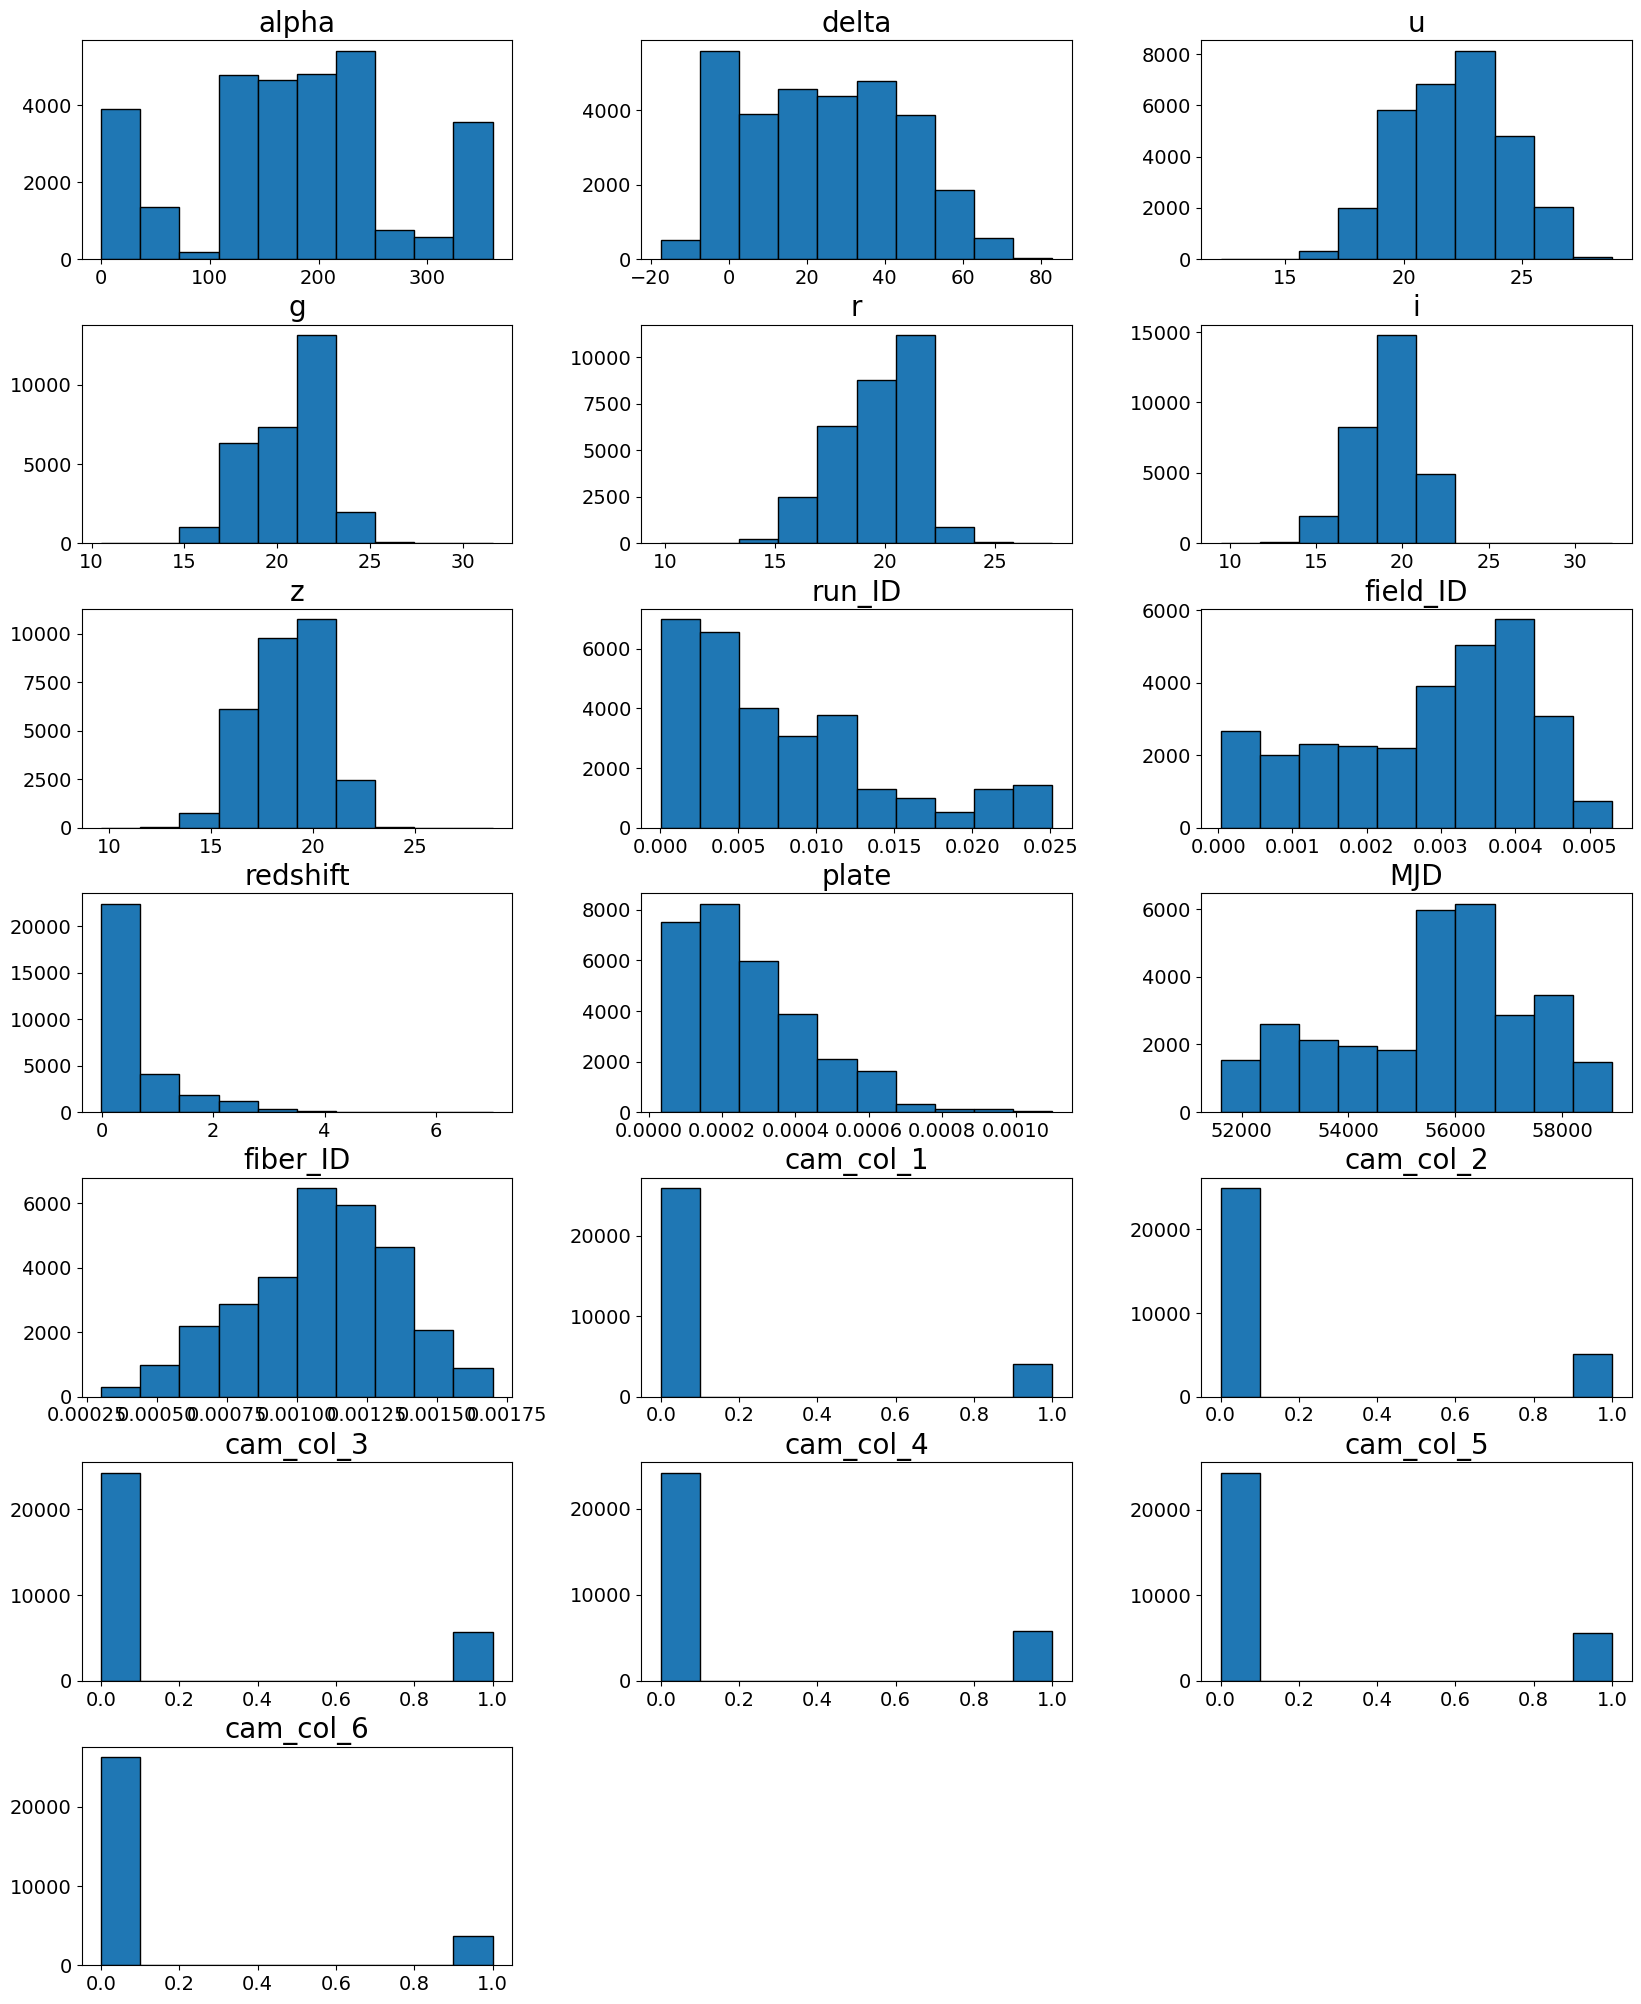

In [154]:
df_clean.hist(figsize=(20, 25), layout=(7,3), grid=False, edgecolor="black");

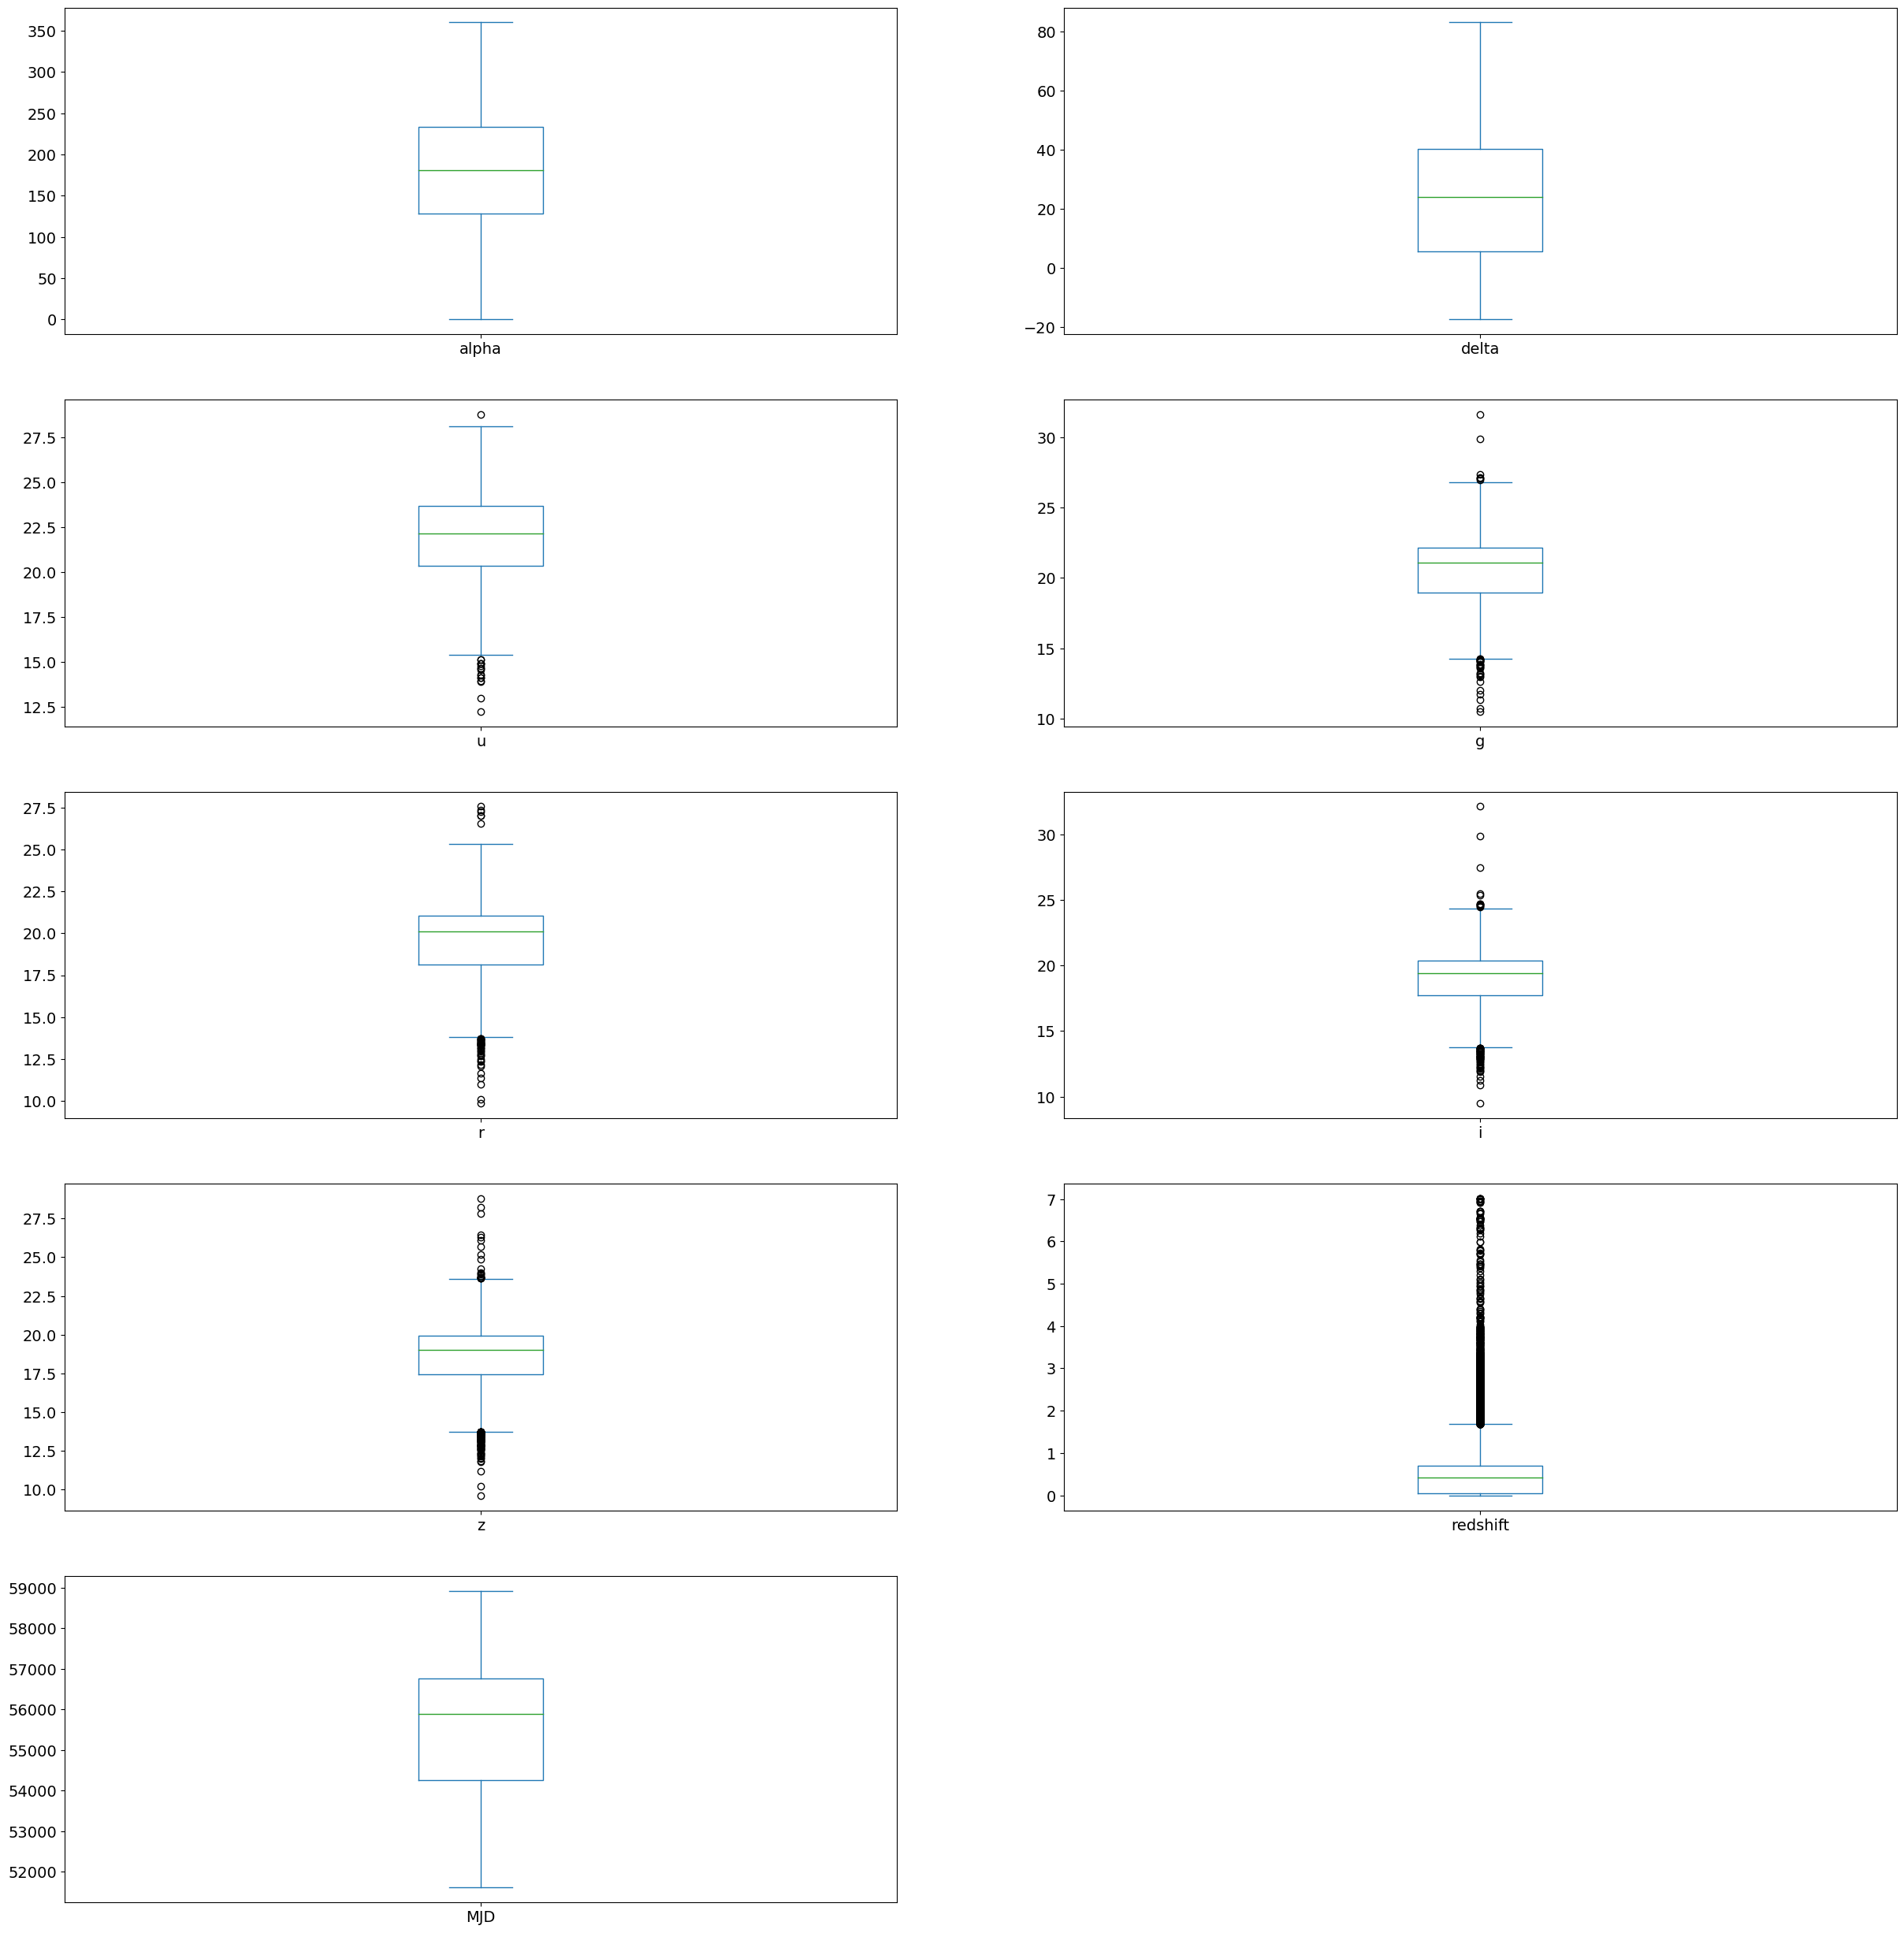

In [155]:
df_clean[numerical_columns].plot(kind='box', subplots=True, figsize=(30,70), layout=(11,2), sharex=False, sharey=False);

All looks well now. We can see the variation (frequency distribution) in "u", "g", and "z"

## Task 2: Normalize or standardize your features as necessary. 
**Carefully decide the normalization or standardization technique used.**

Note - I will use the cleaned dataframe for analysis, and use the original dataset when we start classifying so that it can be split before preprocessing

Standardisation/Normalisation is only applied for numerical features, as they have different ranges that can skew certain distance functions.

Min-max normalisation is very sensitive to the presence of outliers. The max or min value can be tilted to one side, resulting in clustered data.

Standardisation is more resistant to outliers. It works well for normally distributed data, but min-max fares better with data that doesn't follow a specific distribution.

In order to properly map out the distributions, I will apply kde on all the histograms:

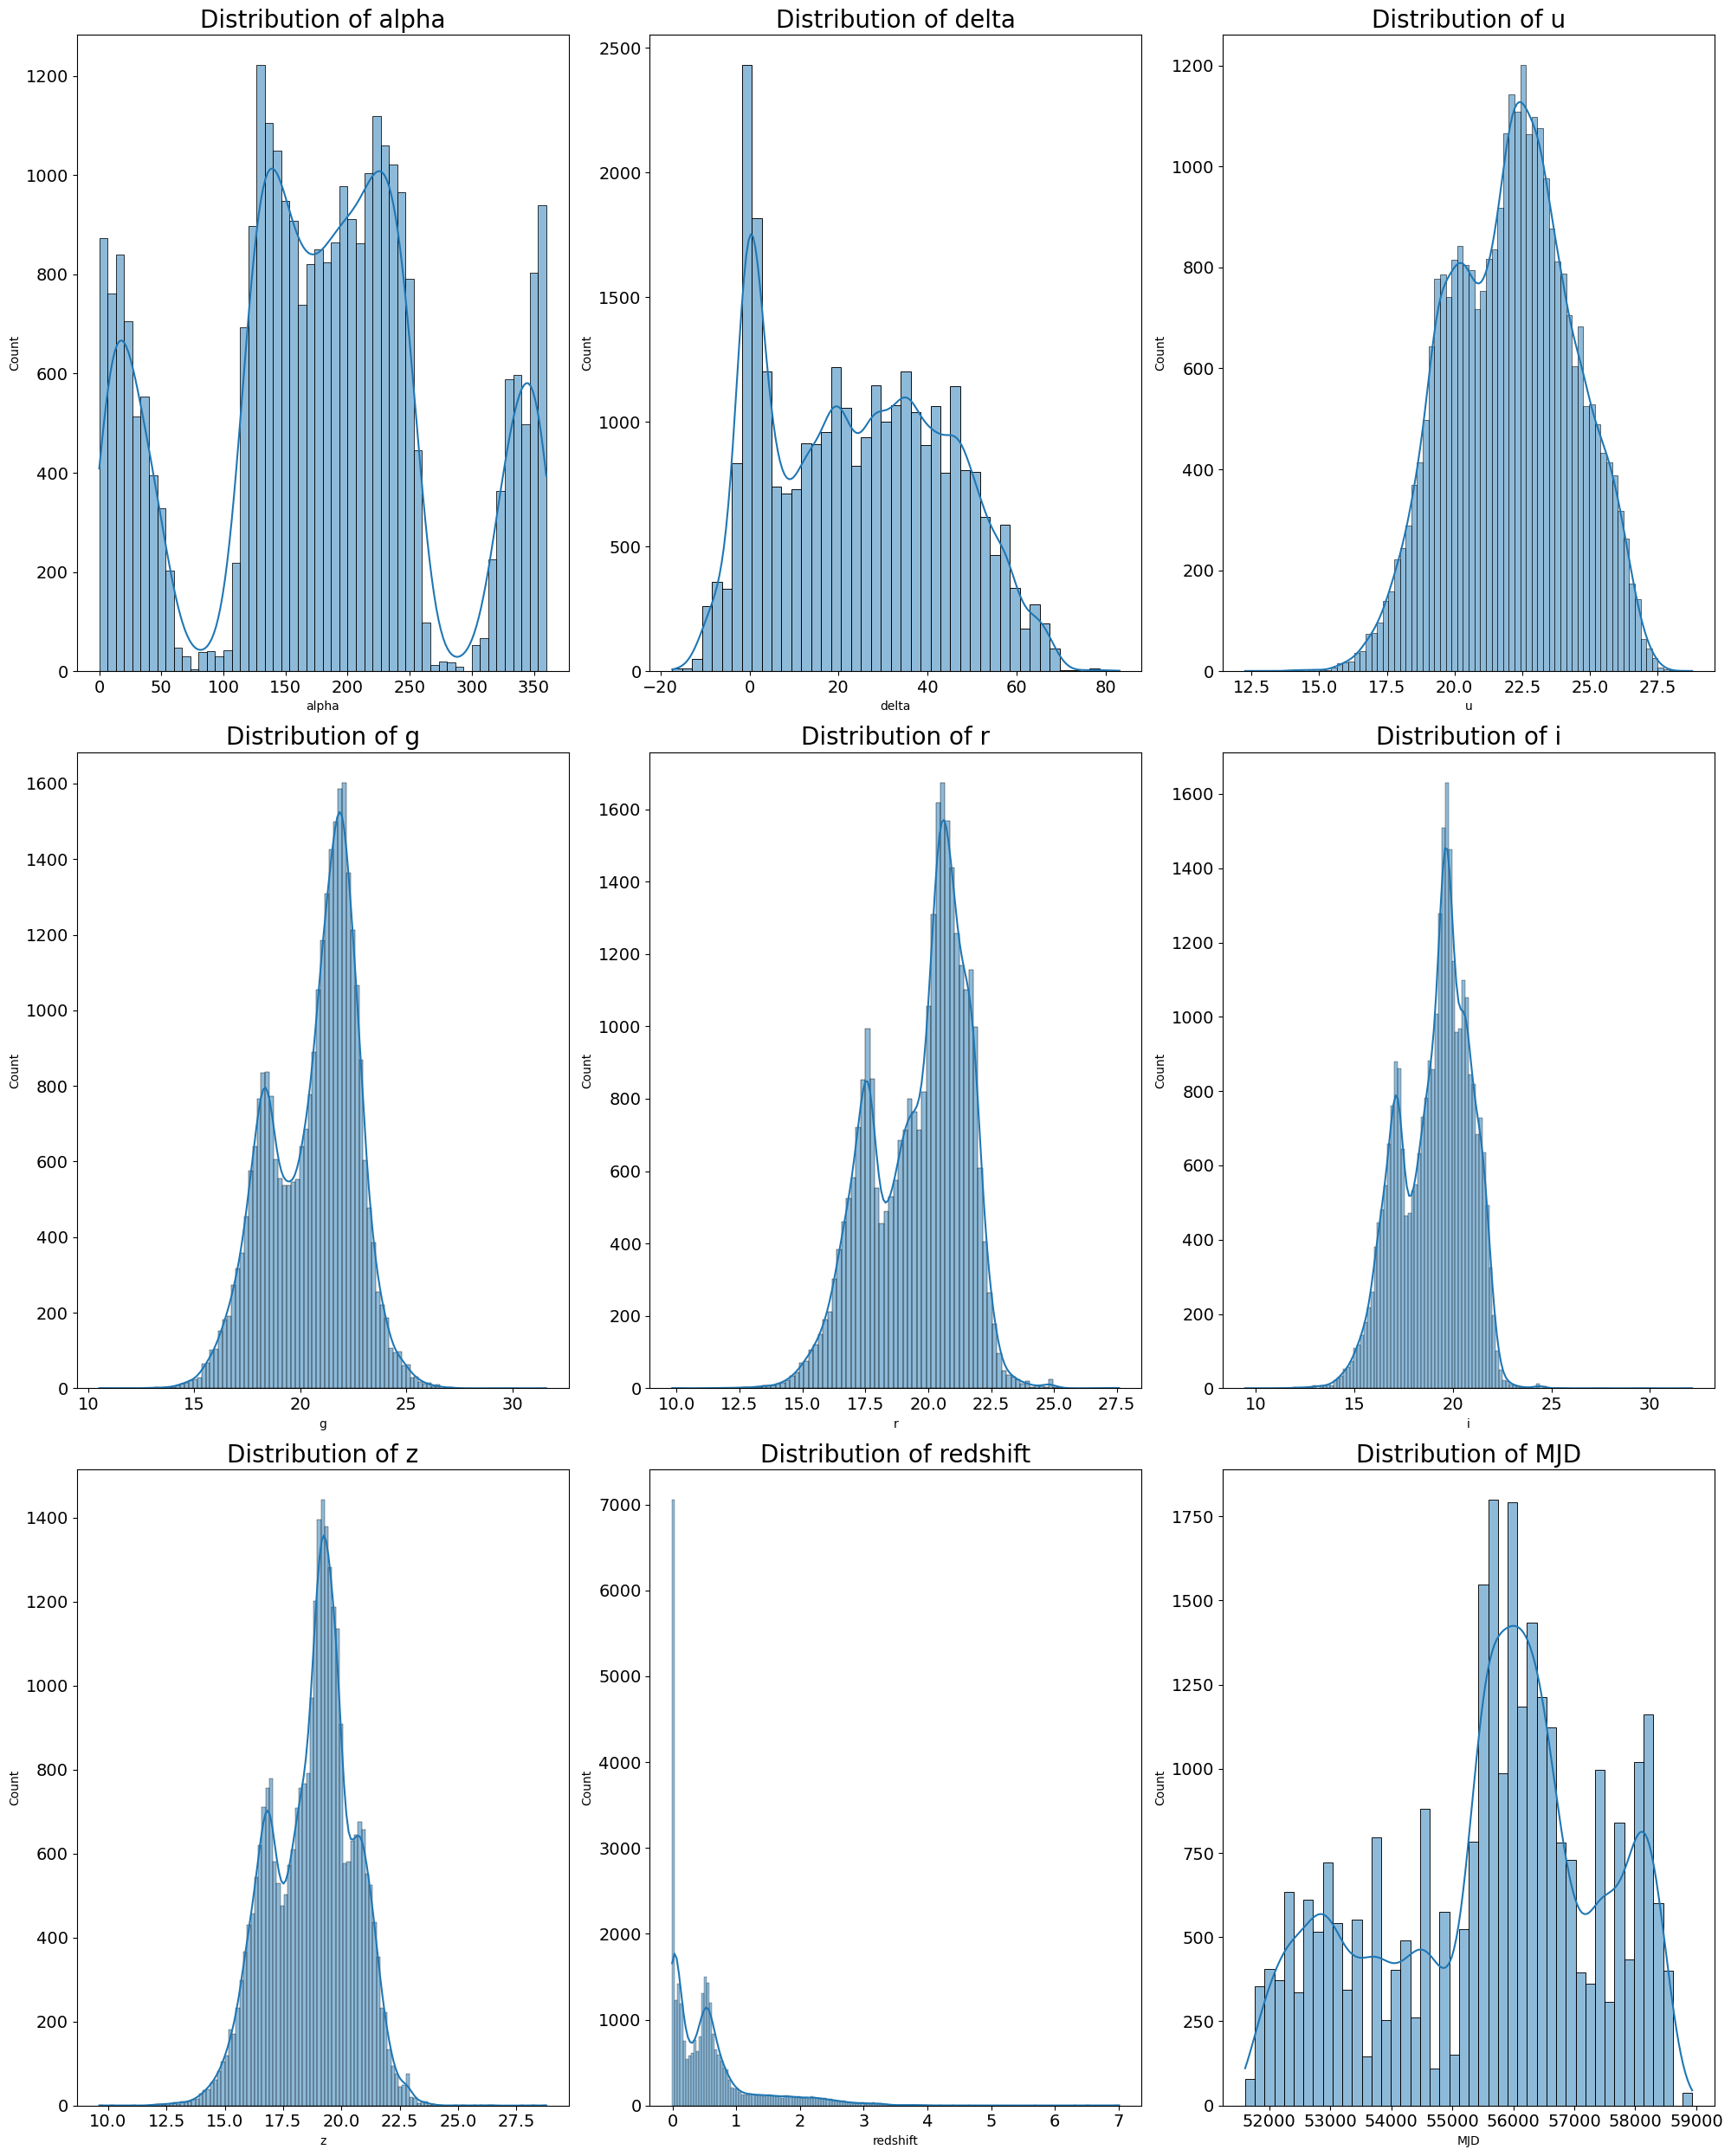

In [157]:
fig, axes = plt.subplots(3, 3, figsize=(20, 25))

axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(df_clean[column], kde=True, ax=axes[i], edgecolor="black")
    axes[i].set_title(f'Distribution of {column}')
    
plt.tight_layout()

I was originally going to use a mix of both normalisation and standardisation. My plan was to use min max normalisation for features without outliers, and standardisation for features with ouliers, and use standardisation for features that are normally distributed, and normalisation for features with no distinct distributions.

However, after observing the data more closely, I believe that standardisation alone would be best. 

Since this is a large dataset, all features have many outliers that I believe should not be removed. There are far too many, removing them or replacing them will certainly affect our results. I also think that most features follow a normal distribution up to a satisfactory level for our purposes. Therefore, I will standardise all of the numerical features.

I'll create a function to standardise the dataset. We will use the same strategy as we did for category encoding.

In [4]:
def standardise_training_set(X_train, numerical_columns):
    
    standardScaler = StandardScaler()

    # Fit scaler on the training set and transform it
    X_train[numerical_columns] = standardScaler.fit_transform(X_train[numerical_columns])

    return X_train, standardScaler  # Return scaler to use it on validation/test sets

# Standardize validation + test sets (using scaler fitted on training data)
def standardise_validation_test_set(df, numerical_columns, standardScaler):
    
    # Apply already fitted scaler to the validation/test sets
    df[numerical_columns] = standardScaler.transform(df[numerical_columns])

    return df

In [ ]:
#Try standardisation on clean dataframe
df_clean, _ = standardise_training_set(df_clean, numerical_columns)

df_clean.head(5)

## Task 3: Carefully decide the evaluation measure that is best suited to this application and the dataset. 

**Justify your choice -- What characteristics of the application and the dataset made you decide the evaluation measure you chose.**

Possible evaluation metrics:
- Accuracy:

    - Accuracy is commonly used, but it isn't the best option if our classes are imbalanced. It could just predict the majority class. 
    
-  Precision
    - Proportion of retreived results that were relevant 
- Recall
    - Proportion of relevant results that were retreived 
    - Can use PR curve to plot trade off between recall and precision

However, balance measures are perfect for imbalanced data:

- F1-score (variant of f-measure)
    - beta is 1 - harmonic mean between precision + recall
    - f1 = (2PR/P+R)
   
These measures are made mainly for binary classification, but we can generalise to multiple classes using OVR or OVO (One vs Rest, and One vs One)
    
No need to consider R^2 and similar algorithms because they're for continuous targets (regression) and we have discrete targets (classification)

In [170]:
#Checking if data is balanced or not
df['class'].value_counts()

GALAXY    17842
STAR       6485
QSO        5673
Name: class, dtype: int64

In [171]:
class_count = df['class'].value_counts()
print("Percentage of class count:")
print(round(class_count / class_count.sum() * 100, 2))

Percentage of class count:
GALAXY    59.47
STAR      21.62
QSO       18.91
Name: class, dtype: float64


We have imbalanced data, with more than 50% of entries being galaxies. 

Therefore, accuracy will not be a suitable evaluation measure.

F1 score is a balance measures so it will be good for imbalanced data. We can also use weights to balance the class frequency. 

F1 would be perfect here as it balances precision and recall, which would be equally important here. 

## Task 4: Compare a decision tree classifier, a kNN classifier and four SVM classifiers 

**(One each with “linear”, “poly”, “rbf” and “sigmoid” kernel) based on the evaluation measure selected in
Task 3.**

**Carefully decide the evaluation methodology for this comparison (e.g., cross validation or a single train/validation/test split or other alternatives).** 

### Evaluation Methodology

k-fold cross validation would not be very useful for such a large dataset. A single validation set would be sufficient, as the large dataset would have enough samples to represent most real-world scenarios.

k-fold validation really is only necessary for smaller datasets where you cannot set aside a portion of the dataset for the test set. Therefore, I would go with a 3-way hold-out split. 

### 3-way Hold-out Split

We will divide our dataset into 3 subsets - a training set, a validation set, and a testing set.

The model will be trained on the training set. The validation set will allow us to tune our model parameters, and the testing set will evaluate our final model with ideal parameters.

I will go with a 70/15/15 split.

However, splitting on an imbalanced dataset is an issue, as most of the minority classes (star and quasar) could end up outside of the training set. This means the model would barely see any such examples, which could greatly affect performance. 

After researching for solutions around this issue, I found the "stratified splitting" strategy. 

(https://medium.com/analytics-vidhya/three-steps-in-case-of-imbalanced-data-and-close-look-at-the-splitter-classes-8b73628a25e6 and https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/)

The stratified split preserves the same proportions of examples in each class as observed in the original dataset, so we will use this for more optimal training and testing.

As discussed earlier, we'll drop irrelevant columns and convert data types before splitting. We'll preprocess the training data after splitting, and transform the validation and test sets accordingly.

#### Split data

In [6]:
#Read df again just in case
df = pd.read_csv('21334466.csv')

In [7]:
df = drop_irrelevant_columns(df)
df, categorical_columns, numerical_columns = convert_correct_data_types(df)

In [8]:
#Separate dataset from target class
y = df.pop('class')
X = df

In [9]:
#Split into 70% training + 30% testing with stratify to preserve percentage of classes in each set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1, stratify=y)

#Split testing set into 50% test and 50% validation (final overall percentage will be 15% and 15%) 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1, stratify=y_test)

#### Preprocess sets appropriately

In [10]:
X_train = remove_wrong_values(X_train)

y_train = one_hot_encode_target(y_train)
y_val = one_hot_encode_target(y_val)
y_test = one_hot_encode_target(y_test)

X_train, freq_encodings = encode_training_set(X_train)

X_val = encode_validation_testing_set(X_val, X_train ,freq_encodings)
X_test = encode_validation_testing_set(X_test, X_train, freq_encodings)

X_train, standardScaler = standardise_training_set(X_train, numerical_columns)

X_val = standardise_validation_test_set(X_val, numerical_columns, standardScaler)
X_test = standardise_validation_test_set(X_test, numerical_columns, standardScaler)

#### Preview shape of split data

In [180]:
X_train.head(5)

,alpha,delta,u,g,r,i,z,run_ID,field_ID,redshift,plate,MJD,fiber_ID,cam_col_1,cam_col_2,cam_col_3,cam_col_4,cam_col_5,cam_col_6
8098,-0.575279,0.956777,-1.450219,-1.530651,-1.123071,-0.825991,-0.628872,0.005952,0.001571,-0.791417,0.000190,-1.883478,0.001190,0,0,0,0,0,1
16692,0.132643,-0.796172,-0.500948,0.028342,-0.370630,-0.554537,-0.593422,0.001571,0.005143,-0.122370,0.000571,0.185798,0.000857,0,0,0,0,0,1
11406,1.765224,-1.199106,-1.127195,-1.464163,-1.584169,-1.601054,-1.617857,0.008476,0.002571,-0.694793,0.000476,-0.064450,0.000810,0,0,0,0,1,0
5867,0.561316,-0.534475,1.009934,0.416713,0.179223,0.063220,0.195288,0.002333,0.004143,-0.363100,0.000429,0.245858,0.001333,0,0,1,0,0,0
17620,0.423179,0.521861,-0.058419,0.644850,1.064747,1.472175,1.567109,0.007667,0.000143,0.696479,0.000095,1.463178,0.001524,0,0,1,0,0,0


In [183]:
y_train.head(5)

,GALAXY,QSO,STAR
8098,0,0,1
16692,1,0,0
11406,1,0,0
5867,1,0,0
17620,0,1,0


All looks well. The categorical features have been encoded, the numerical features have been standardised, and there are no erroneous values or irrelevant columns.

#### Verify size of training/validation/testing sets

In [184]:
X_train.shape[0]

21000

In [185]:
X_val.shape[0]

4500

In [186]:
X_test.shape[0]

4500

Now that our data has been split appropriately, we can start running our classifiers.

Note - I will evaluate the classifiers on the validation set so that we can directly compare the results before and after parameter tuning in the next section

## K-Nearest Neighbour Classifier

### Train and Test Model

In [196]:
#Create KNN classifier instance and train it with our training data (fitting)
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [197]:
#Evaluate using evaluation metric - F1
#Needed to change average from default of binary to weighted (because we have multiple classes)
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
f1

0.9006260224173281

## Decision Trees

In [198]:
#Train model
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

#Test model
y_pred = dtc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
f1

0.9621708533596791

## SVM Classifiers

#### Linear

In [199]:
svc = OneVsRestClassifier(SVC(kernel='linear'))
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
f1

0.8958366427443406

#### Sigmoid

In [192]:
svc = OneVsRestClassifier(SVC(kernel='sigmoid'))
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
f1

0.6642784358896551

#### Poly

In [200]:
svc = OneVsRestClassifier(SVC(kernel='poly'))
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
f1

0.9320549955810109

#### RBF

In [201]:
svc = OneVsRestClassifier(SVC(kernel='rbf'))
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
f1

0.9506482687375017

Note - I originally used class_weight='balanced' with SVM kernels and decision trees, but I have found that f1 is consistently higher without it 

## Comparison of Classifiers


| Classifier | F1-Score (weighted)| 
|------------|-------------|
| Decision Trees     |       96.217%       | 
| KNN | 90.0626% | 
|Linear SVM | 89.584% |
| Sigmoid SVM | 66.428% |
| Poly SVM | 93.205% | 
| RBF SVM | 95.065% | 

Decision trees perform the best with an f1 score of 96.217%, with RBF SVM Kernel coming in at a close second with a score of 95.065%. 

Most classifiers do extremely well, at over 90% F-1, with exception to the Sigmoid SVM.

This is probably due to the fact that the Sigmoid kernel expects a certain structure as input - "The sigmoid kernel is generally problematic or invalid because it is difficult to have positive parameters. The sigmoid function is now not widely used in research because it has a major drawback, namely that the output value range of the sigmoid function is not centered on zero."  -- from https://medium.com/analytics-vidhya/introduction-to-svm-and-kernel-trick-part-1-theory-d990e2872ace

RBF performed the best out of the SVMs because it is the best option for complex datasets. It has an infinite number of dimensions. More dimension means more chances to define better hyperplanes. 

Linear kernels, on the other hand, are the simplest. They are the best for linearly separable data, and they don't define any transformation to high dimensions. 

Poly is good for non-linearly separable data (as is RBF), because it uses the kernel trick, so it makes sense that it's the second best performer among SVMs.

KNN performed similarly to the linear SVM. It's relatively lower performance may be due to the number of features in our dataset. Our dataset may be too complex, with too many dimensions, to properly use distance measures to classify data.

Decision trees worked best for a number of possible reasons.
They work very well for discrete data. Since we encoded and standardised our data, we had clearer boundaries between values (less continuous, more partitioned), which may have improved performance.
Our results suggest that our data is not linearly separable. SVMs struggle with linear separability more than decision trees, possibly leading to slightly worse performance than decision trees.

Decision tees may also deal with imbalanced data better than SVMs and KNN, especially considering that we didn't use any techniques to adjust class imbalance yet (e.g. SMOTE). We may consider this in the bonus question.

(SVM characteristics paraphrased from https://www.kaggle.com/code/gorkemgunay/understanding-parameters-of-svm)

**Explore the effect of different parameter settings on these classifiers and find the winner classifier/ parameter setting.**

**Why do you think you got those comparison results?**

We will use the validation set for parameter tuning here.

### KNN
#### Number of Neighbours

In [22]:
#Changing model parameters
for n in range(1, 11, 2):
    print('\nn_neighbors = ', n)
    knn_clf = KNeighborsClassifier(n_neighbors=n) 
    # fit the KNN model on the credit risk training data
    knn_clf.fit(X_train, y_train)

    # predict on the validation dataset 
    y_pred = knn_clf.predict(X_val)
    print('F1 score: ', round(f1_score(y_val, y_pred, average='weighted'), 5))


n_neighbors =  1
F1 score:  0.903

n_neighbors =  3
F1 score:  0.90626

n_neighbors =  5
F1 score:  0.90063

n_neighbors =  7
F1 score:  0.90042

n_neighbors =  9
F1 score:  0.89453


It looks like k=3 produces the best results, at 90.626%, and f1 slowly deteriorates as k increases after that.

### Decision Trees
#### Min sample Leafs and Depth

In [27]:
#Changing model parameters
for depth in range(4, 26, 4):
    print('\nMax depth = ', depth)
    for samples_in_leaf in [2, 10]:
        print('\nMin samples leaf = ', samples_in_leaf)
        dtc = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples_in_leaf) 
        # fit the decision trees model on the credit risk training data
        dtc.fit(X_train, y_train)

        # predict on the validation dataset
        y_pred = dtc.predict(X_val)
        print('F1 score: ', round(f1_score(y_val, y_pred, average='weighted'), 5))


Max depth =  4

Min samples leaf =  2
F1 score:  0.96375

Min samples leaf =  10
F1 score:  0.96375

Max depth =  8

Min samples leaf =  2
F1 score:  0.96975

Min samples leaf =  10
F1 score:  0.9693

Max depth =  12

Min samples leaf =  2
F1 score:  0.96522

Min samples leaf =  10
F1 score:  0.97024

Max depth =  16

Min samples leaf =  2
F1 score:  0.96219

Min samples leaf =  10
F1 score:  0.96912

Max depth =  20

Min samples leaf =  2
F1 score:  0.95989

Min samples leaf =  10
F1 score:  0.97062

Max depth =  24

Min samples leaf =  2
F1 score:  0.95953

Min samples leaf =  10
F1 score:  0.96958


The best parameters are max_depth=20 and min_samples_leaf=10, giving an F1 score of 97.062%

In [65]:
#Test different criterion (given previous best parameters)
for criterion in ['entropy', 'gini', 'log_loss']:
    print('Criterion = ', criterion)
    dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion=criterion) 
    # fit the decision trees model on the credit risk training data
    dtc.fit(X_train, y_train)

    # predict on the validation dataset
    y_pred = dtc.predict(X_val)
    print('F1 score: ', round(f1_score(y_val, y_pred, average='weighted'), 5))

Criterion =  entropy
F1 score:  0.97248
Criterion =  gini
F1 score:  0.96865
Criterion =  log_loss
F1 score:  0.97178


Entropy performs best at 97.248%

### SVM 

Here are the parameters we will consider and test:
#### C
If we choose large value for C, we get small margin but lower misclassification

If we choose small value for C, we get large margin but high misclassification compared to large C value.

#### Degree
It is just used by poynomial kernel and ignored by other kernels. High polynomial degree yield more flexible decision boundary. 

#### Gamma
Used by non-linear kernels. Higher gamma provides more fitting, so if the gamma parameter is too high, it can cause overfitting. 

Link - https://www.kaggle.com/code/gorkemgunay/understanding-parameters-of-svm

In [193]:
#Changing model parameters
for C in [0.1,1,10, 100]:
    print('C = ', C)
    svc = OneVsRestClassifier(SVC(kernel='linear', C=C))
    svc.fit(X_train, y_train)

    # predict on the validation dataset 
    y_pred = svc.predict(X_val)
    print('F1 score: ', round(f1_score(y_val, y_pred, average='weighted'), 5))

C =  0.1
F1 score:  0.8924
C =  1
F1 score:  0.89584
C =  10
F1 score:  0.89928
C =  100
F1 score:  0.90022


The best C score is C=100 with an F1-score of about 90%.

I believe that the largest value of C gave the best score because of the following:
- a High value of C increases penalties for misclassifications, so the SVM will try to minimise misclassifications. This comes at a cost of overfitting, but in this case, it makes the classifier understand the patterns in the data better, leading to a higher F1-score.

- Therefore, the more sensitive our classifier is to the dataset, the better it performs, as it fits the data better by understanding its complex rules.

In [207]:
#Changing model parameters
for C in [0.1,1,10, 100]:
    print('C = ', C)
    svc = OneVsRestClassifier(SVC(kernel='sigmoid', C=C))
    svc.fit(X_train, y_train)

    # predict on the validation dataset 
    y_pred = svc.predict(X_val)
    print('F1 score: ', round(f1_score(y_val, y_pred, average='weighted'), 5))

C =  0.1
F1 score:  0.6805
C =  1
F1 score:  0.66988
C =  10
F1 score:  0.66588
C =  100
F1 score:  0.66624


C=0.1 performs best for sigmoid at 68.05%

Let's try this out on our best performing kernel as well.

In [33]:
#Changing model parameters
for C in [0.1,1,10, 100]:
    print('C = ', C)
    svc = OneVsRestClassifier(SVC(kernel='rbf', C=C))
    svc.fit(X_train, y_train)

    # predict on the validation dataset 
    y_pred = svc.predict(X_val)
    print('F1 score: ', round(f1_score(y_val, y_pred, average='weighted'), 5))

C =  0.1
F1 score:  0.92264
C =  1
F1 score:  0.95065
C =  10
F1 score:  0.9626
C =  100
F1 score:  0.96461


The results are excellent. A C = 100 gives 96.46% F1-score, suggesting that the classifiers will benefit from higher C values.

In [29]:
#Changing model parameters
for degree in [1,3,5,7]:
    print('Degree = ', degree)
    svc = OneVsRestClassifier(SVC(kernel='poly', degree=degree))
    svc.fit(X_train, y_train)

    # predict on the validation dataset 
    y_pred = svc.predict(X_val)
    print('F1 score: ', round(f1_score(y_val, y_pred, average='weighted'), 5))

Degree =  1
F1 score:  0.8925
Degree =  3
F1 score:  0.93205
Degree =  5
F1 score:  0.89212
Degree =  7
F1 score:  0.83659


The best degree is degree=3 for polynomial kernels, with an F1-score of 93%. 

This is still slightly worse than rbf at the default parameters, so we will not consider this for the best classifier.

In [203]:
#Changing model parameters
for gamma in [0.01,0.1,1,10]:
    print('Gamma = ', gamma)
    svc = OneVsRestClassifier(SVC(kernel='rbf', C=100, gamma=gamma))
    svc.fit(X_train, y_train)

    # predict on the validation dataset 
    y_pred = svc.predict(X_val)
    print('F1 score: ', round(f1_score(y_val, y_pred, average='weighted'), 5))

Gamma =  0.01
F1 score:  0.95809
Gamma =  0.1
F1 score:  0.9645
Gamma =  1
F1 score:  0.92869
Gamma =  10
F1 score:  0.64136


A Gamma value of 0.1 performed the best (96.45%), and the f1 score greatly declines for larger values (64.14%).
 
From what I understand about the gamma parameter (https://www.geeksforgeeks.org/gamma-parameter-in-svm/#whatis-the-gammaparameter):
- A lower gamma parameter simplifies the model, risking underfitting. Each individual data point reaches further, resulting in a less complex decision boundary (May not understand data well enough to do well in training or validation)
- A higher gamma value fits the data more closely, risking overfitting. Each single data point is confined to a smaller space, so the decision boundary is tight around some data points. (More noise, learns the data too much, may not generalise well to the validation set)

A gamma score of 0.1 may be the right balance to avoid underfitting and overfitting. It aims to understand the most relevant parts of the data, but not to study it so closely as to pick up irrelevant patterns that reduce performance.

| Classifier | Parameter | Best Value | F1-Score | Original Performance |
|------------|-------------|-------------|-------------|-------------|
| KNN | Number of Neighbours (k) | 3 | 90.626% | 90.063% |
| Decision Trees     | Max Depth, Min Sample Leaf | 20, 10 | 97.062% |  96.217%        | 
| Decision Trees     | Criterion | Entropy | 97.248% |  96.217%        | 
|Linear SVM | C | 100 | 90.022% |89.584% | 
| Sigmoid | C | 0.1 |  68.05% | 66.43% |
| Poly SVM | Degree | 3 | 93.205% | 93.205% |
| RBF SVM | Gamma | 0.1 | 96.45% | 95.065% | 

KNN's performance boosts by ~0.6% by using k=3

Decision trees's F1 increases by ~1% after applying max depth=20, min sample leaf=10, and using entropy as the criterion.

Linear SVM's performance boosts by ~0.5% after using C=100

Sigmoid SVM's F1 increases by ~1.5% after using C=0.1

Poly SVM doesn't change since the default degree was the best one (3)

RBF SVM's F1 score increases by about 1.5% after using C=100 and Gamma 0.1.

### Winner Classifier/Parameter Setting

If we consider all possible classifiers, our winner classifier/parameter setting is Decision Tree Classifier with max_depth=20 and min_samples_leaf=10, and criterion of entropy, giving an F1 score of 97.062%.

Among the SVM classifier, rbf performs the best with gamma=0.1 and C=100, giving an F-1 score of 96.45%.

**Are you surprised at the relative performance of “linear”, “rbf” and “sigmoid” kernels?**

Overall, I was surprised at how well the linear kernel performed, given the complexity of the data (19 features). The nonlinear kernels (rbf, poly) perform better than the linear kernel, suggesting that the data is not linearly separable.

RBF works well with non-linear and high-dimensional data, so it is no surprise that it performs best. 

"Unlike linear or polynomial kernels, RBF is more complex and efficient at the same time.It can combine multiple polynomial kernels with different degrees to project the non-linearly separable data into higher dimensional space." - https://www.pycodemates.com/2022/10/the-rbf-kernel-in-svm-complete-guide.html

Sigmoid was discussed earlier when first running the SVM classifiers. Given Sigmoid's characteristics, its poor performance was completely expected.

## Task 5: Based on a filter technique, identify the three most discriminative features and the three least discriminative features in this dataset. 

**Run the SVM classifiers with the four kernels on the top three and the bottom three features. How do the results compare?**

I chose information gain filtering to be my filter technique.

## Information Gain Filtering

The mutual_info_classif function expects the target class to be one-dimensional. Therefore, I will use the target's value before one-hot encoding. We can revert from one-hot encoding using np.argmax

In [14]:
y_train.values

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]], dtype=uint8)

In [28]:
y_train_unencoded = np.argmax(y_train.values, axis=1)

y_train_unencoded

array([2, 0, 0, ..., 2, 2, 0], dtype=int64)

In [17]:
i_scores = mutual_info_classif(X_train, y_train_unencoded)

# put the i_scores in a dataframe and sort
features_info_gain = pd.DataFrame(i_scores,index = X_train.columns, columns =['I-Gain'])
features_info_gain.sort_values(by=['I-Gain'],ascending=False,inplace=True)
features_info_gain

,I-Gain
redshift,0.797389
MJD,0.186593
z,0.145400
g,0.117216
i,0.106371
u,0.094136
run_ID,0.080818
r,0.072153
delta,0.042801
alpha,0.039457


In [18]:
#Select top 3 and bottom 3 features
top3 = features_info_gain[:3].index
bottom3 = features_info_gain[-3:].index

In [211]:
#Train model with all SVM kernels on top 3 features

print(f"Using top 3 features by Information gain: {list(top3)}")

svc = OneVsRestClassifier(SVC(kernel='linear', C=100, gamma=0.1))
svc.fit(X_train[top3], y_train)
y_pred = svc.predict(X_test[top3])
print(f"Kernel: Linear\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='sigmoid', C=0.1, gamma=0.1))
svc.fit(X_train[top3], y_train)
y_pred = svc.predict(X_test[top3])
print(f"Kernel: Sigmoid\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='poly', C=100, gamma=0.1, degree=3))
svc.fit(X_train[top3], y_train)
y_pred = svc.predict(X_test[top3])
print(f"Kernel: Poly\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='rbf', C=100, gamma=0.1))
svc.fit(X_train[top3], y_train)
y_pred = svc.predict(X_test[top3])
print(f"Kernel: RBF\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

Using top 3 features by Information gain: ['redshift', 'MJD', 'z']
Kernel: Linear
F1 score: 0.8539708784702911
Kernel: Sigmoid
F1 score: 0.6740096356922098
Kernel: Poly
F1 score: 0.8569899857335703
Kernel: RBF
F1 score: 0.9440732436348939


As usual, rbf performs the best, and sigmoid the worst. 

However, all classifiers did slightly worse with the top 3 best features than they did with all of the features. 

This suggests that more features in the dataset were relevant and contributed to the performance of the classifier. 

On the next task, we may try to pick more than 3 features and see if we can get better performance.

In [210]:
#Train model with all SVM kernels on bottom 3 features

print(f"Using bottom 3 features by Information gain: {list(bottom3)}")

svc = OneVsRestClassifier(SVC(kernel='linear', C=100, gamma=0.1))
svc.fit(X_train[bottom3], y_train)
y_pred = svc.predict(X_test[bottom3])
print(f"Kernel: Linear\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='sigmoid', C=0.1, gamma=0.1))
svc.fit(X_train[bottom3], y_train)
y_pred = svc.predict(X_test[bottom3])
print(f"Kernel: Sigmoid\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='poly', C=100, gamma=0.1, degree=3))
svc.fit(X_train[bottom3], y_train)
y_pred = svc.predict(X_test[bottom3])
print(f"Kernel: Poly\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='rbf', C=100, gamma=0.1))
svc.fit(X_train[bottom3], y_train)
y_pred = svc.predict(X_test[bottom3])
print(f"Kernel: RBF\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

Using bottom 3 features by Information gain: ['cam_col_4', 'cam_col_5', 'cam_col_6']
Kernel: Linear
F1 score: 0.44378362980508723
Kernel: Sigmoid
F1 score: 0.44378362980508723
Kernel: Poly
F1 score: 0.44378362980508723
Kernel: RBF
F1 score: 0.44378362980508723


I was very surprised to see how badly the classifiers performed, and that their performance was completely identical! 

Regardless of the type of kernel used, all classifiers had an F1-score of 44.378%.

The poor F1 score suggests that these features are irrelevant to classification, or that at the very least, not much information is gained by using them for classification.

For completion's sake (and for task 7), I will also compute the F1-scores of the top 3 features on the decision tree and knn models:

In [19]:
dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='entropy')
dtc.fit(X_train[top3], y_train)
y_pred = dtc.predict(X_test[top3])
print(f"Decision Trees\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

Decision Trees
F1 score: 0.9567471391133234


In [21]:
knn_clf = KNeighborsClassifier(n_neighbors=3) 
knn_clf.fit(X_train[top3], y_train)
y_pred = knn_clf.predict(X_test[top3])
print(f"Decision Trees\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

Decision Trees
F1 score: 0.9365599377094097


## Task 6: Carefully identify the most discriminating features to predict the ternary outcome of the dataset using one wrapper feature selection technique. 

**This should be done for each of the decision tree, kNN and four SVM classifiers from part Task 4.**

I will use sequential forward selection as my wrapper feature selection technique

### Perform sequential forward selection

I'll make a function to perform sequential forward selection on each model. It will take the classifier as input, and print the graph and resulting dataframe, as well as the number of features with highest performance.

In [11]:
def forward_selection(model, model_name):
    sfs_forward = SFS(model, k_features=10, forward=True, scoring='f1_weighted')
    sfs_forward = sfs_forward.fit(X_train, y_train)
    
    fig1 = plot_sfs(sfs_forward.get_metric_dict(), ylabel='F1')

    plt.title(f'Sequential Forward Selection on {model_name}')
    plt.grid()
    plt.show()
    print(sfs_forward.k_feature_names_)
    df_forward = pd.DataFrame.from_dict(sfs_forward.get_metric_dict()).T
    df_forward['avg_score'] = df_forward['avg_score'].astype(float)
    max_score = df_forward[df_forward['avg_score'] == df_forward['avg_score'].max()]

    return df_forward, max_score

### Decision Tree 

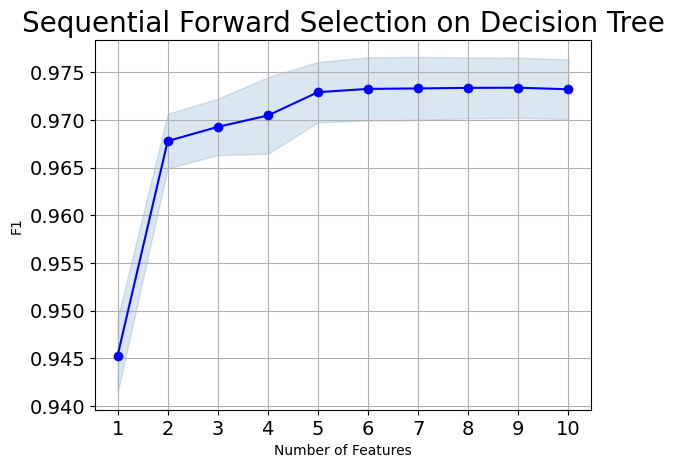

('alpha', 'u', 'g', 'i', 'redshift', 'MJD', 'cam_col_1', 'cam_col_2', 'cam_col_3', 'cam_col_4')


In [228]:
dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='entropy') 
df_forward_dt, max_dt = forward_selection(dtc, "Decision Tree")

In [229]:
df_forward_dt

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.9428290260924158, 0.9406575826865747, 0.948...",0.945277,"(redshift,)",0.005016,0.003903,0.001951
2,"(2, 9)","[0.9637325684768311, 0.9677867891282259, 0.965...",0.967796,"(u, redshift)",0.003673,0.002858,0.001429
3,"(2, 9, 11)","[0.9650520288806282, 0.9681164437134153, 0.967...",0.969282,"(u, redshift, MJD)",0.003804,0.00296,0.00148
4,"(2, 5, 9, 11)","[0.9641712844969197, 0.9727242808252251, 0.967...",0.970477,"(u, i, redshift, MJD)",0.005158,0.004013,0.002007
5,"(2, 3, 5, 9, 11)","[0.9672247149811255, 0.9763752099418066, 0.972...",0.972923,"(u, g, i, redshift, MJD)",0.004073,0.003169,0.001585
6,"(0, 2, 3, 5, 9, 11)","[0.9670781973368036, 0.9763436851145764, 0.972...",0.973268,"(alpha, u, g, i, redshift, MJD)",0.004259,0.003313,0.001657
7,"(0, 2, 3, 5, 9, 11, 14)","[0.9670781973368036, 0.9763436851145764, 0.972...",0.973315,"(alpha, u, g, i, redshift, MJD, cam_col_2)",0.00425,0.003307,0.001653
8,"(0, 2, 3, 5, 9, 11, 14, 16)","[0.9674708145824016, 0.9764866355623889, 0.972...",0.973375,"(alpha, u, g, i, redshift, MJD, cam_col_2, cam...",0.004106,0.003195,0.001597
9,"(0, 2, 3, 5, 9, 11, 14, 15, 16)","[0.9674708145824016, 0.9763436851145764, 0.972...",0.973391,"(alpha, u, g, i, redshift, MJD, cam_col_2, cam...",0.004059,0.003158,0.001579
10,"(0, 2, 3, 5, 9, 11, 13, 14, 15, 16)","[0.9674708145824016, 0.9764866355623889, 0.972...",0.973227,"(alpha, u, g, i, redshift, MJD, cam_col_1, cam...",0.004026,0.003132,0.001566


Note that the F1 score declines after we reach a certain number of features (F1 score drops after num_features=5, suggesting that the information gain filter could have performed worse because we picked too few features).

Let's get the number and subset of features with highest F1 score:

In [230]:
max_dt

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
9,"(0, 2, 3, 5, 9, 11, 14, 15, 16)","[0.9674708145824016, 0.9763436851145764, 0.972...",0.973391,"(alpha, u, g, i, redshift, MJD, cam_col_2, cam...",0.004059,0.003158,0.001579


We can see the highest F1 score at num_features = 9 with an avg_score of 97.339%.

At num features = 3, our score is 96.928%

### KNN

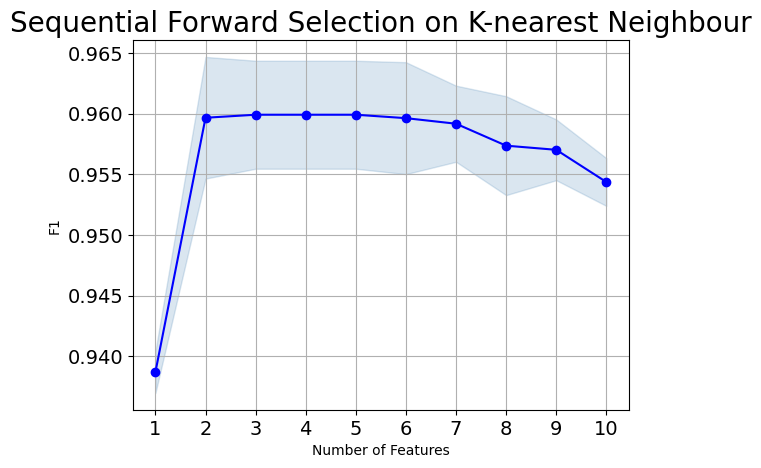

('g', 'r', 'i', 'z', 'run_ID', 'field_ID', 'redshift', 'plate', 'fiber_ID', 'cam_col_6')


In [231]:
knn = KNeighborsClassifier(n_neighbors=3) 

df_forward_knn, max_knn = forward_selection(knn, "K-nearest Neighbour")

In [232]:
df_forward_knn

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.9392044401890302, 0.9356388731553993, 0.938...",0.938689,"(redshift,)",0.002211,0.00172,0.00086
2,"(3, 9)","[0.9534194330260172, 0.9556986163018718, 0.958...",0.959661,"(g, redshift)",0.006447,0.005016,0.002508
3,"(3, 7, 9)","[0.9544208874880452, 0.9566583464428569, 0.958...",0.959910,"(g, run_ID, redshift)",0.005722,0.004452,0.002226
4,"(3, 7, 9, 10)","[0.9544208874880452, 0.9566583464428569, 0.958...",0.959910,"(g, run_ID, redshift, plate)",0.005722,0.004452,0.002226
5,"(3, 7, 9, 10, 12)","[0.9544208874880452, 0.9566583464428569, 0.958...",0.959910,"(g, run_ID, redshift, plate, fiber_ID)",0.005722,0.004452,0.002226
6,"(3, 7, 8, 9, 10, 12)","[0.9539528618073425, 0.9561895578873133, 0.958...",0.959628,"(g, run_ID, field_ID, redshift, plate, fiber_ID)",0.00593,0.004614,0.002307
7,"(3, 5, 7, 8, 9, 10, 12)","[0.956156981975297, 0.9563558754120687, 0.9579...",0.959169,"(g, i, run_ID, field_ID, redshift, plate, fibe...",0.004033,0.003138,0.001569
8,"(3, 4, 5, 7, 8, 9, 10, 12)","[0.9534972632659392, 0.9549379793897718, 0.953...",0.957359,"(g, r, i, run_ID, field_ID, redshift, plate, f...",0.005242,0.004079,0.002039
9,"(3, 4, 5, 6, 7, 8, 9, 10, 12)","[0.9543743637768727, 0.9552910288648562, 0.955...",0.957017,"(g, r, i, z, run_ID, field_ID, redshift, plate...",0.00322,0.002505,0.001253
10,"(3, 4, 5, 6, 7, 8, 9, 10, 12, 18)","[0.9518353428496023, 0.9538991334137896, 0.952...",0.954362,"(g, r, i, z, run_ID, field_ID, redshift, plate...",0.00253,0.001969,0.000984


In [233]:
max_knn

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(3, 7, 9)","[0.9544208874880452, 0.9566583464428569, 0.958...",0.95991,"(g, run_ID, redshift)",0.005722,0.004452,0.002226
4,"(3, 7, 9, 10)","[0.9544208874880452, 0.9566583464428569, 0.958...",0.95991,"(g, run_ID, redshift, plate)",0.005722,0.004452,0.002226
5,"(3, 7, 9, 10, 12)","[0.9544208874880452, 0.9566583464428569, 0.958...",0.95991,"(g, run_ID, redshift, plate, fiber_ID)",0.005722,0.004452,0.002226


There are several ideal subsets - we'll take the one with the least amount of features for simplicity

### SVM

Note - I had to reduce the number of features from 10 to 3 so that I could get the output for the SVM kernels.

They took a very long time to run, with the poly kernel taking over 10 hours to run (I had to run it overnight). 

I added a verbose argument to the feature selection method so that I could see how long it takes to run, if at all.

In [222]:
#New function with variable num_features
def forward_selection(model, model_name, num_features):
    sfs_forward = SFS(model, k_features=num_features, forward=True, floating=False, scoring='f1_weighted', verbose=2, n_jobs=-1, cv=2)
    sfs_forward = sfs_forward.fit(X_train, y_train)
    
    # Plot and return results
    fig1 = plot_sfs(sfs_forward.get_metric_dict(), ylabel='F1')
    plt.title(f'Sequential Forward Selection on {model_name}')
    plt.grid()
    plt.show()
    
    print(sfs_forward.k_feature_names_)
    df_forward = pd.DataFrame.from_dict(sfs_forward.get_metric_dict()).T
    df_forward['avg_score'] = df_forward['avg_score'].astype(float)
    max_score = df_forward[df_forward['avg_score'] == df_forward['avg_score'].max()]

    return df_forward, max_score


#### Linear

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  19 | elapsed:  2.8min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:  4.2min remaining:   47.6s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  4.3min finished

[2024-10-24 17:45:33] Features: 1/3 -- score: 0.8486600436967344[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:  1.9min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  3.6min remaining:   42.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.7min finished

[2024-10-24 17:49:14] Features: 2/3 -- score: 0.8646388519848416[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  17 | elapsed:  2.0min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:  2.2min remaining:   53.9s
[Parallel(n

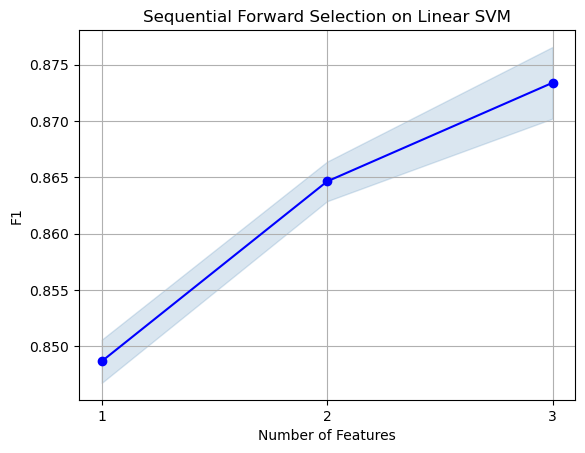

('u', 'z', 'redshift')


In [16]:
svc_linear = OneVsRestClassifier(SVC(kernel='linear', C=1), n_jobs=-1)

df_forward_linear, max_linear = forward_selection(svc_linear, "Linear SVM", 3) 

In [17]:
df_forward_linear

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.8467416413616948, 0.850578446031774]",0.848660,"(redshift,)",0.008254,0.001918,0.001918
2,"(2, 9)","[0.8628812786871032, 0.8663964252825801]",0.864639,"(u, redshift)",0.007562,0.001758,0.001758
3,"(2, 6, 9)","[0.8702162354550421, 0.8765810019716529]",0.873399,"(u, z, redshift)",0.013693,0.003182,0.003182


In [18]:
 max_linear

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(2, 6, 9)","[0.8702162354550421, 0.8765810019716529]",0.873399,"(u, z, redshift)",0.013693,0.003182,0.003182


#### Sigmoid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  19 | elapsed:  2.3min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:  3.5min remaining:   39.5s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  3.8min finished

[2024-10-28 23:29:53] Features: 1/3 -- score: 0.6695100619186213[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:  2.1min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  3.0min remaining:   36.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.2min finished

[2024-10-28 23:33:04] Features: 2/3 -- score: 0.6695100619186213[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  17 | elapsed:  1.9min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:  2.6min remaining:  1.1min
[Parallel(n

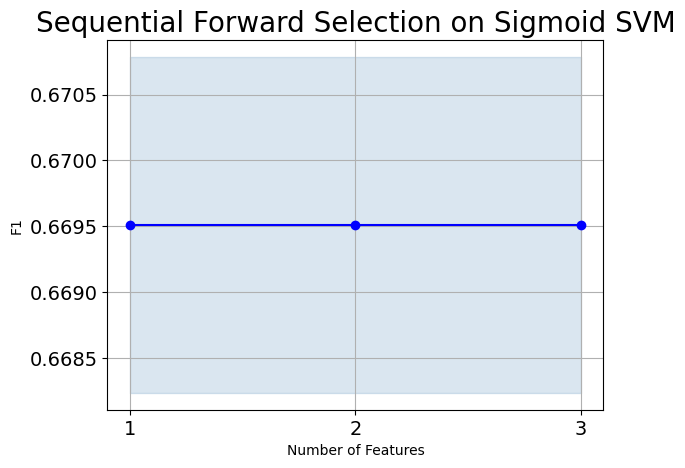

('field_ID', 'redshift', 'plate')


In [223]:
svc_sigmoid = OneVsRestClassifier(SVC(kernel='sigmoid', C=0.1), n_jobs=-1)

df_forward_sigmoid, max_sigmoid = forward_selection(svc_sigmoid, "Sigmoid SVM", 3)

In [235]:
df_forward_sigmoid

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.668233080966152, 0.6707870428710906]",0.66951,"(redshift,)",0.005494,0.001277,0.001277
2,"(8, 9)","[0.668233080966152, 0.6707870428710906]",0.66951,"(field_ID, redshift)",0.005494,0.001277,0.001277
3,"(8, 9, 10)","[0.668233080966152, 0.6707870428710906]",0.66951,"(field_ID, redshift, plate)",0.005494,0.001277,0.001277


In [236]:
max_sigmoid

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.668233080966152, 0.6707870428710906]",0.66951,"(redshift,)",0.005494,0.001277,0.001277
2,"(8, 9)","[0.668233080966152, 0.6707870428710906]",0.66951,"(field_ID, redshift)",0.005494,0.001277,0.001277
3,"(8, 9, 10)","[0.668233080966152, 0.6707870428710906]",0.66951,"(field_ID, redshift, plate)",0.005494,0.001277,0.001277


#### Poly

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  19 | elapsed:  7.8min remaining: 16.9min
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed: 71.4min remaining: 13.4min
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed: 228.9min finished

[2024-10-26 00:01:57] Features: 1/3 -- score: 0.8434805185652063[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:  1.7min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  2.3min remaining:   28.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.4min finished

[2024-10-26 00:04:22] Features: 2/3 -- score: 0.8534762205103787[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  17 | elapsed:  1.4min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:  1.6min remaining:   40.9s
[Parallel(

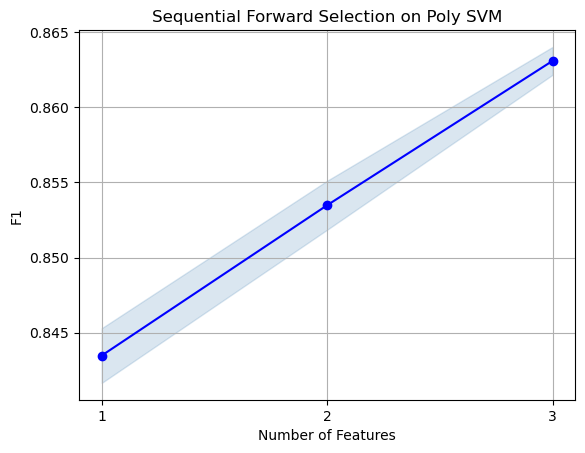

('redshift', 'cam_col_3', 'cam_col_4')


In [15]:
svc_poly = OneVsRestClassifier(SVC(kernel='poly', C=1), n_jobs=-1)

df_forward_poly, max_poly = forward_selection(svc_poly, "Poly SVM", 3)

In [16]:
df_forward_poly

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.8416619011080932, 0.8452991360223194]",0.843481,"(redshift,)",0.007825,0.001819,0.001819
2,"(9, 15)","[0.8518481140530639, 0.8551043269676935]",0.853476,"(redshift, cam_col_3)",0.007005,0.001628,0.001628
3,"(9, 15, 16)","[0.8621486024988416, 0.864000350007492]",0.863074,"(redshift, cam_col_3, cam_col_4)",0.003984,0.000926,0.000926


In [17]:
 max_poly

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(9, 15, 16)","[0.8621486024988416, 0.864000350007492]",0.863074,"(redshift, cam_col_3, cam_col_4)",0.003984,0.000926,0.000926


#### RBF

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  19 | elapsed:  4.1min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:  6.0min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  6.1min finished

[2024-10-25 17:26:02] Features: 1/3 -- score: 0.9313988572602694[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:  1.0min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  1.7min remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.7min finished

[2024-10-25 17:27:46] Features: 2/3 -- score: 0.9472856924831443[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  17 | elapsed:   58.4s remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:  1.2min remaining:   28.8s
[Parallel(n

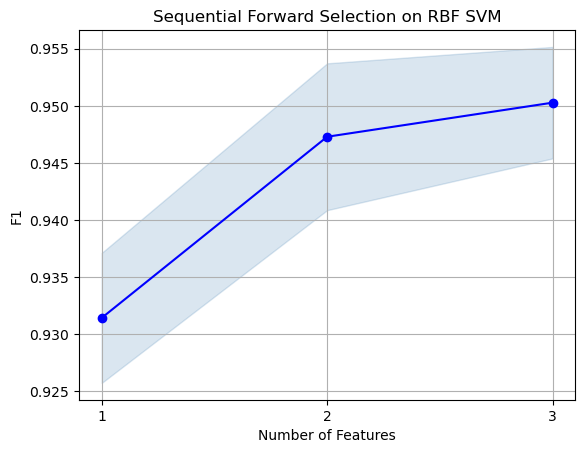

('g', 'i', 'redshift')


In [15]:
svc_rbf = OneVsRestClassifier(SVC(kernel='rbf', C=1), n_jobs=-1)

df_forward_rbf, max_rbf = forward_selection(svc_rbf, "RBF SVM", 3)

In [16]:
df_forward_rbf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.9256976597450303, 0.9371000547755085]",0.931399,"(redshift,)",0.02453,0.005701,0.005701
2,"(3, 9)","[0.9408480518969449, 0.9537233330693436]",0.947286,"(g, redshift)",0.027699,0.006438,0.006438
3,"(3, 5, 9)","[0.9453876323340453, 0.9551631420636709]",0.950275,"(g, i, redshift)",0.02103,0.004888,0.004888


In [17]:
max_rbf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(3, 5, 9)","[0.9453876323340453, 0.9551631420636709]",0.950275,"(g, i, redshift)",0.02103,0.004888,0.004888


**Report and discuss the differences between the feature subsets produced by the filter (Task 5) and the wrapper technique.**

In order to directly compare the feature subsets, we will only consider the subsets at num_features = 3

### Feature subsets produced by feature selection techniques

| Feature Selection Technique | Feature Subset | F1-score |
|------------|-------------|-------------|
| IG Filter (Decision Tree) | ('redshift', 'MJD', 'z') | 95.675% |
| IG Filter (KNN) | ('redshift', 'MJD', 'z') | 93.656% |
| IG Filter (Linear SVM) | ('redshift', 'MJD', 'z') |85.397% |
| IG Filter (Sigmoid SVM) | ('redshift', 'MJD', 'z') | 67.401% |
| IG Filter (Poly SVM) | ('redshift', 'MJD', 'z') | 85.699%|
| IG Filter (RBF SVM) | ('redshift', 'MJD', 'z') | 94.407%|
| SFS (Decision Tree) | ('g', 'i', 'redshift') | 96.928% |
| SFS (KNN) | ('g', 'i', 'redshift') | 95.991% |
| SFS (Linear SVM) | ('u', 'z', 'redshift') | 87.340% |
| SFS (Sigmoid SVM) | ('field_ID', 'redshift', 'cam_col_1') | 66.951% |
| SFS (Poly SVM) | ('redshift', 'cam_col_3', 'cam_col_4') | 86.307% |
| SFS (RBF SVM) | ('g', 'i', 'redshift') | 95.028% |

- Since filter techniques don't take a classifier into account when selecting features, all information gain filters on different classifiers have the same feature subset. SFS is a wrapper technique, so it produces unique subsets for each classifier.
- SFS may pick features that work well together, since it takes feature relationships into account, while information gain may pick features that are efficient on their own, since it assesses features individually
- Redshift appears in all subsets, meaning it may be the most important feature in the dataset.
- 3 SFS classifiers picked the same subset of features. SFS on Decision trees, KNN, and RBF SVM all result in  ('g', 'i', 'redshift'). They also all achieve very high scores, indicating that they're relevant features. 
- Decision trees and RBF SVM are our best classifiers, indicating that ('g', 'i', 'redshift') might be the best subset if we're only choosing 3 features
- SFS Sigmoid and poly SVMS pick peculiar features (cam_col features and field_ID) which other classifiers don't pick. However, they also don't perform very well, so those may have been unsuitable choices. 

## Task 7: Compare the performance of different classifiers using the different feature subsets found in Tasks 5 and 6 and compare it to the results on original dataset that you reported in Task 4. 


**Have the results improved or worsened after feature selection?**

**Is the relative performance of different classifiers and configuration settings in line with your expectation?**

In order to directly compare the feature subsets, we will only consider the subsets at num_features = 3

### F1-Score Performance of different classifiers using different feature subsets
| Classifier | Original (with optimal parameters)| Information Gain Filter (num_features=3) | Forward Sequential Search (num_features=3) |
|------------|-------------|--------------------|------------------|
| Decision Trees  |  96.217%  | 95.675% | 96.928% |
| KNN | 90.063% | 93.655% | 95.991% |
|Linear SVM | 89.584% | 85.397% | 87.340% |
| Sigmoid SVM |	68.05%	 | 67.401% | 66.951% |
| Poly SVM | 93.205% | 85.699% | 86.307% |
| RBF SVM | 95.065% | 94.407% | 95.028% |

The subset chosen from information gain performed slightly worse than the full set on all classifiers (except for KNN).

However, forward sequential search subsets performed better than almost all information gain subsets. (except for Sigmoid)

They even performed better than the original full set for decision trees and knn. (KNN's performance went up from 90% to nearly 96% !)

Information gain might have performed worse than forward sequential search for a couple of reasons.

Information gain is a filtering technique, which doesn't consider relationships between features. Because it considers feature relationships in isolation, it might have missed some important correlations that forward sequential search was able to detect.

Filter techniques also don't include a classifier in their feature selection, so it may have selected features that don't perform well with certain classifiers. On the other hand, forward sequential search  accounts for the classifier when picking the best features, which may result in better performance.

I was surprised to see that performance was highest on the full original feature set for most classifiers. This might be due to us taking too little features when selecting. 

If we compare SFS at the highest performance with the original feature set, we get this:


### F1-Score Performance of different classifiers using different feature subsets
| Classifier | Original (with optimal parameters)| Size of Feature Subset | SFS F1 Performance | Feature Subset |
|------------|-------------|--------------------|------------------|------------------|
| Decision Trees  |  96.217%  | 9 | 97.339% | (alpha, u, g, i, redshift, MJD, cam_col_2, cam...)|
| KNN | 90.063% | 3 | 95.991% | (g, run_ID, redshift) |
|Linear SVM | 89.584% | 3 | 87.340% | ('u', 'z', 'redshift') |
| Sigmoid SVM |	68.05%	 | 3 | 66.951% | ('field_ID', 'redshift', 'cam_col_1') |
| Poly SVM | 93.205% | 3 | 86.307% | ('redshift', 'cam_col_3', 'cam_col_4') |
| RBF SVM | 95.065% | 3 | 95.028% | ('g', 'i', 'redshift')|

Note - Unfortunately, since we couldn't run more than 3 feature subsets on the SVM classifiers, we can't compare their best possible performance

After using SFS, F1 score for decision trees is 97.339%, which is much higher than the original feature set's performance at 96.217%.

As mentioned before, knn also performs better after SFS.

If given more computational power and time, SVMs may also produce better results using SFS on larger feature subsets.

## Task 8: Plot the ROC curves for the three classes and the different classification models.

(using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

We will compare the ROC curves produced by the classifiers with a dummy classifier, which should act like a trivial random classifier (classifying with 50% F1 score per class).

In [29]:
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train_unencoded)

# Get predicted probabilities for each class
dummy_proba = np.array(dummy_classifier.predict_proba(X_test)) 

In [ ]:
#We need this for plotting
y_test = y_test.to_numpy()

In [31]:
classes = ["GALAXY", "QSO", "STAR"]

In [32]:
#Plot ROC curves for all classes in one plot, given a model/classifier
def plot_roc_curve(model, model_name):
    
    ovr_model = OneVsRestClassifier(model)
    ovr_model.fit(X_train, y_train)

    # Use predict_proba if available, otherwise use decision_function
    #Some classifiers have predict_proba, others don't so we'll use decision function for them instead
    if hasattr(ovr_model, 'predict_proba'):
        y_score = ovr_model.predict_proba(X_test)
    else:
        y_score = ovr_model.decision_function(X_test)
    
    #Handle potential NaNs in y_score
    if np.isnan(y_score).any():
        y_score = np.nan_to_num(y_score)

    #Set up one plot
    fig, ax = plt.subplots(figsize=(8, 6))

    #Loop over each class
    for i in range(3):
        #Plot curve
        RocCurveDisplay.from_predictions(
            y_test[:, i],
            y_score[:, i],
            name=f"{classes[i]} vs rest",
            ax=ax
        )
        
        #Plot dummy classifier ROC curve on same axis
        #Only plot once (same result for all 3 classes)
        if (i == 0):
            RocCurveDisplay.from_predictions(
                y_test[:, i],
                dummy_proba[:, i],
                name=f"Dummy Classifier",
                linestyle="--",
                ax=ax
            )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"ROC Curve for {model_name} (One-vs-Rest)"
    )
    ax.legend(loc="lower right")
    plt.show()

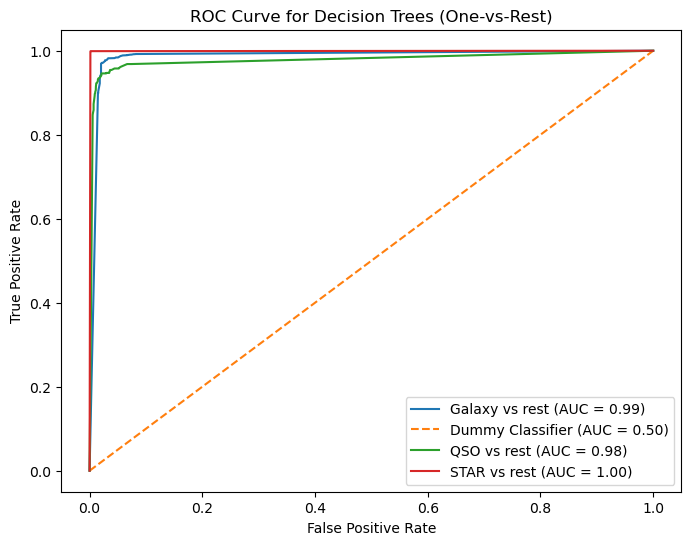

In [107]:
plot_roc_curve(DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='entropy'), 'Decision Trees')

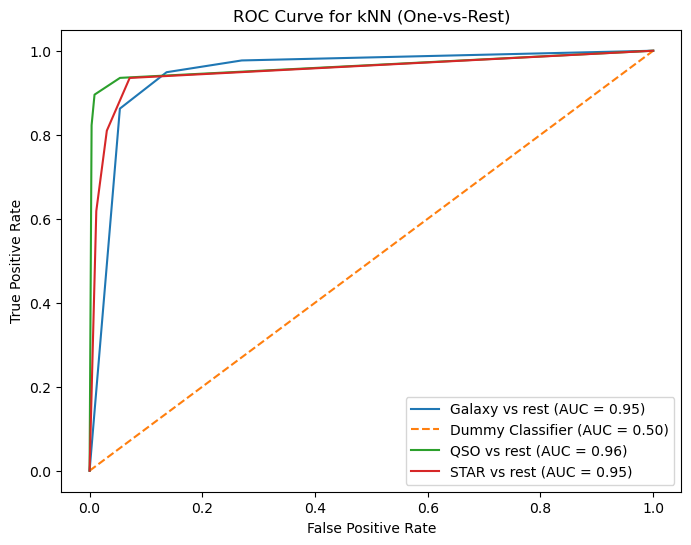

In [108]:
plot_roc_curve(KNeighborsClassifier(n_neighbors=3), 'kNN')

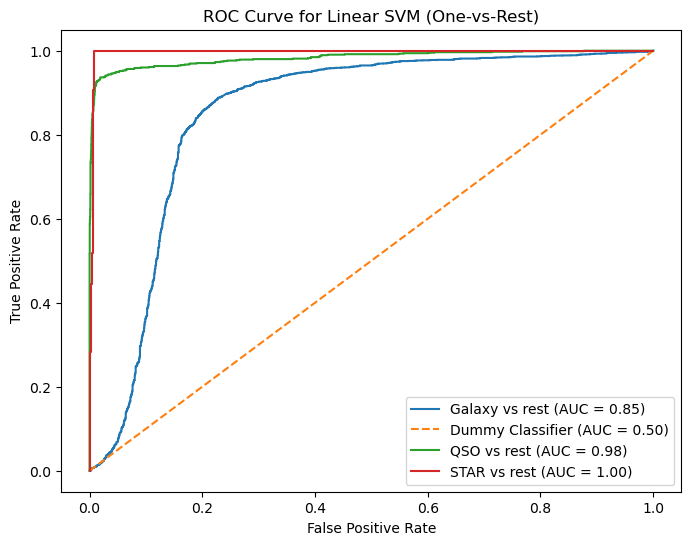

In [109]:
plot_roc_curve(SVC(kernel='linear', C=100, probability=True), 'Linear SVM')

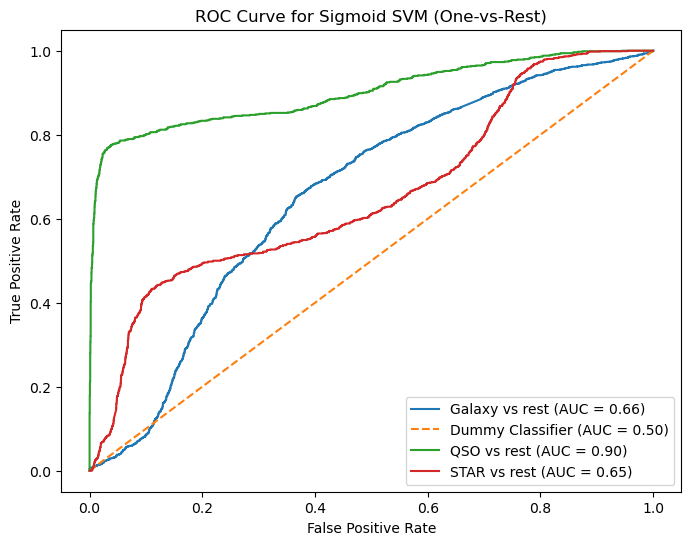

In [110]:
plot_roc_curve(SVC(kernel='sigmoid', C=.1, probability=True), 'Sigmoid SVM')

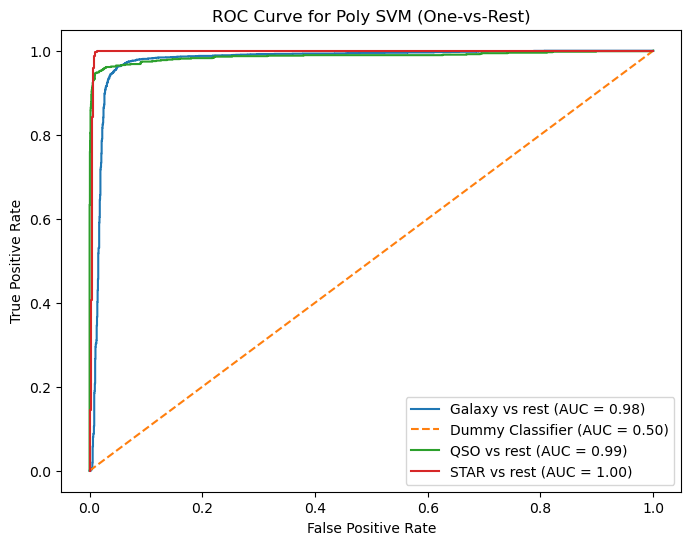

In [111]:
plot_roc_curve(SVC(kernel='poly', C=100, degree=3, probability=True), 'Poly SVM')

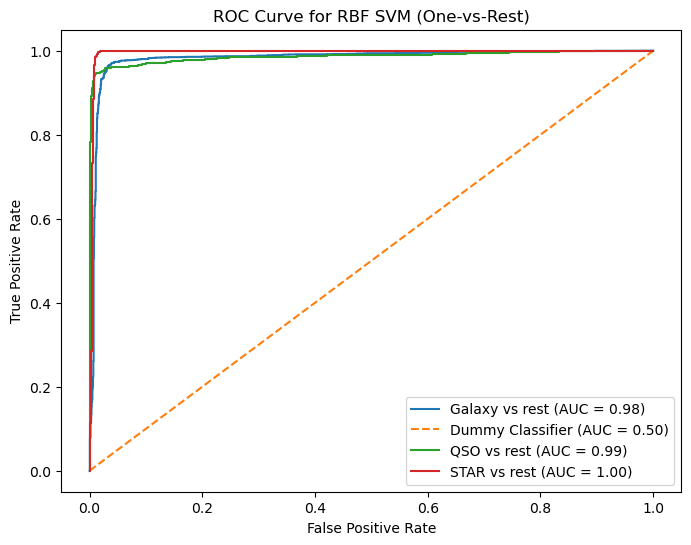

In [112]:
plot_roc_curve(SVC(kernel='rbf', C=100, gamma=0.1, probability=True), 'RBF SVM')

(It took about two hours to run in full)

**What do you learn from these ROC curves? Which classifier/configuration is best suited for this task? Are you satisfied with the performance?**

Let's summarise the curves into a table for quick inspection:

### AUC per classifier and per class
| Classifier | Galaxy vs Rest | QSO vs Rest | Star vs Rest|
|------------|-------------|--------------------|------------------|
| Decision Trees  | 0.99  | 0.98 | 1 |
| KNN | 0.95 | 0.96 | 0.95 | 
|Linear SVM | 0.85 | 0.98 | 1 | 
| Sigmoid SVM | 0.66 | 0.90 | 0.65 | 
| Poly SVM | 0.98 | 0.99 | 1 | 
| RBF SVM | 0.98 | 0.99 | 1 | 

The best classifiers are decision trees, poly SVM, and rbf SVM, with nearly perfect TRP/FRP ratio for all classes. (0.98 on each class at least).
This means that these classifiers have excellent separation between the classes.

It's very surprising to see 100% True Positives for Stars vs Rest in most classifiers.

KNN performed quite well too, with ~95% on all classes, but it struggles to separate the classes as well as the best classifiers.

Linear and Sigmoid SVMs have the lowest scores. It is expected of Sigmoid to perform poorly, as we have seen that previously. However, it is surprising that there is such a high TPR for QSO vs rest across all classifiers, with most classifiers at 98% rate, and even Sigmoid at 90%.

It seems Star vs rest was easiest to classify, followed by QSO, and then Galaxy. (Red star vs rest line was closest to top left, meaning it performed best). Interesting results, as Galaxy is the majority class. 

Overall, these are great results! Very high, nearly perfect TPRs, which is ideal. We have extremely good performance, but it's not overly-optimistic. There are enough miclassifications to account for possible noise or ambiguous cases. 

## Task 9: BONUS

**This part is open-ended -- Take the exploration and the discussion deeper than asked and gain further insights into**

**(i) correlation of the various features with the target class**
 
**(ii) feature selection and feature importance,**
 
**(iii) relative performance of different classifiers (different kernels in case of SVM) and different parameter settings w.r.t different evaluation measures and**
 
**(iv) effect of different ways of imputing missing values on the final performance of different classifiers.**

There are a couple of things I would like to discover and analyse:
- Discover correlations between features using heatmaps and ANOVA
- See how PCA compares to feature selection
- See how different filter algorithms perform using gini index
- Assess feature importance using ExtraTrees
- Compare sequential backward selection to sequential forward selection
- Assess the performance of different  classifiers, like the Laplacian SVM kernel, Random Forest Classifier, Logistic Regression (OVR), and Stochastic Gradient Descent.

## Correlation of various features with target class - Correlation Matrix

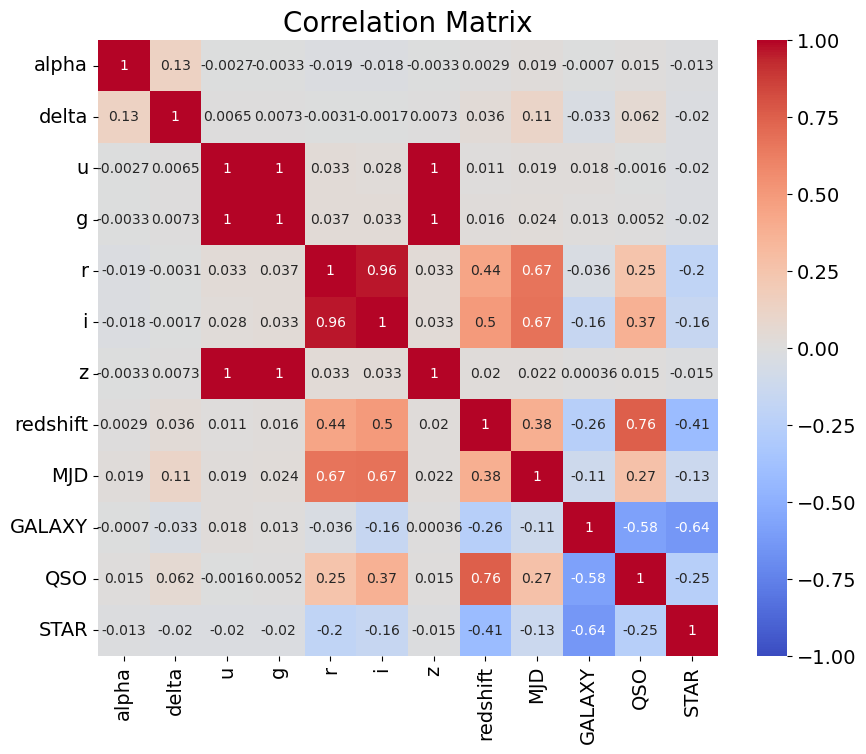

In [234]:
#Create correlation matrix
#I'll assess the relationship between the features and the one-hot encoded target feature
correlation_matrix = pd.concat([X[numerical_columns], one_hot_encode_target(y)], axis=1).corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

The most important relationships are those between the target features and the other descriptive features, so we'll focus on those columns/rows.

Redshift, as expected from earlier analysis, has the highest correlation to the target feature. Positively correlated with QSO (0.76), and slightly negatively correlated with the other classes. This shows that redshift can nearly classify correctly, just on its own.

Other relevant features include "r", "i", and "MJD", which are slightly positively correlated with QSO, and slightly negatively correlated with the other classes. When these features are combined with redshift, we do get a high performing classifier.

### PCA for Feature Extraction

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_train_transformed = pca.fit(X_train).transform(X_train)
X_test_transformed = pca.transform(X_test)

# Proportion of variance explained for each components
print("Variance explained by each of the principal components: ", pca.explained_variance_ratio_)

Variance explained by each of the principal components:  [0.51063119 0.11805248 0.09694974 0.08674075]


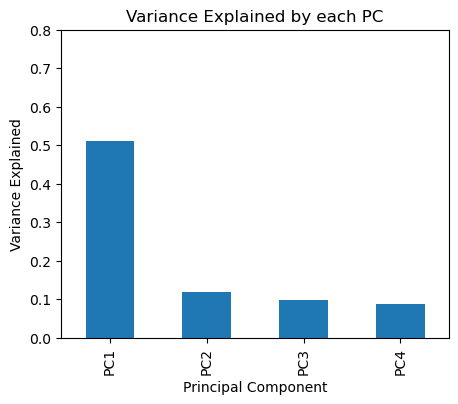

In [79]:
#Let's plot our results
df = pd.DataFrame(pca.explained_variance_ratio_, 
                  index=['PC1','PC2','PC3','PC4'],columns =['var'])

plot = df.plot.bar(figsize=(5,4))
plot.set_title("Variance Explained by each PC")
plot.set_ylabel("Variance Explained")
plot.set_xlabel("Principal Component")
plot.set_ylim([0,0.8])
plot.get_legend().remove();

Over half of the variance in the data can be explained by one principcal component

In [18]:
#Try classifiers on transformed dataset

print(f"Using transformed features from PCA:")

dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='entropy') 
dtc.fit(X_train_transformed, y_train)
y_pred = dtc.predict(X_test_transformed)
print(f"Decision Tree F1 score: {f1_score(y_test, y_pred, average='weighted')}")

Using transformed features from PCA:
Decision Tree F1 score: 0.7953713379558814


Unfortunately, the results are much worse after applying PCA, with an F1-score of 79.537%, whereas before applying PCA, the F1-score was 97.5336%.

The low score might be due to some loss of information when the original features were combined and transformed to create new features. While the new features explain the variance in the data well, it may be more difficult for the classifier to pick out areas to properly separate the data per class.

Let's try running it on RBF SVM instead:

In [36]:
#Try classifiers on transformed dataset

print(f"Using transformed features from PCA:")

dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='entropy') 

svc = OneVsRestClassifier(SVC(kernel='rbf', C=100, gamma=0.1))
svc.fit(X_train_transformed, y_train)
y_pred = svc.predict(X_test_transformed)
print(f"RBF SVM F1 score: {f1_score(y_test, y_pred, average='weighted')}")

Using transformed features from PCA:
RBF SVM F1 score: 0.8168588584416085


Once again, the performance declines after applying PCA. It seems as if transforming the data obscures the features that can properly classify the data.

### Gini Index Filter for Feature Selection

In [16]:
#Gini index is a criterion for decision trees, so we'll calculate it using decision tree 
dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='gini') 
dtc.fit(X_train, y_train)

# Display top features
top_features = pd.DataFrame({'Feature': X_train.columns, 'Gini': dtc.feature_importances_})
top_features = top_features.sort_values(by='Gini', ascending=False)

top_features

,Feature,Gini
9,redshift,0.911755
3,g,0.041637
2,u,0.019455
5,i,0.007984
6,z,0.006314
4,r,0.003839
11,MJD,0.002522
0,alpha,0.001547
1,delta,0.001483
8,field_ID,0.001111


Redshift has the highest importance, at around 91% ! This is much higher than information gain's measure for redshift, which was 79%. Let's classify based on the top 3 and bottom 3 features.

In [17]:
#Select top 3 and bottom 3 features
top3 = top_features[:3]['Feature'].values
bottom3 = top_features[-3:]['Feature'].values

In [18]:
#Train model with all SVM kernels on top 3 features

print(f"Using top 3 features by Gini Index: {list(top3)}")

dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='entropy')
dtc.fit(X_train[top3], y_train)
y_pred = dtc.predict(X_test[top3])
print(f"Decision Trees\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

knn_clf = KNeighborsClassifier(n_neighbors=3) 
knn_clf.fit(X_train[top3], y_train)
y_pred = knn_clf.predict(X_test[top3])
print(f"KNN\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='linear', C=100, gamma=0.1))
svc.fit(X_train[top3], y_train)
y_pred = svc.predict(X_test[top3])
print(f"Kernel: Linear\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='sigmoid', C=0.1, gamma=0.1))
svc.fit(X_train[top3], y_train)
y_pred = svc.predict(X_test[top3])
print(f"Kernel: Sigmoid\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='poly', C=100, gamma=0.1, degree=3))
svc.fit(X_train[top3], y_train)
y_pred = svc.predict(X_test[top3])
print(f"Kernel: Poly\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='rbf', C=100, gamma=0.1))
svc.fit(X_train[top3], y_train)
y_pred = svc.predict(X_test[top3])
print(f"Kernel: RBF\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

Using top 3 features by Gini Index: ['redshift', 'g', 'u']
Decision Trees
F1 score: 0.9725654323673892
KNN
F1 score: 0.9586336429103661
Kernel: Linear
F1 score: 0.8737526455597617
Kernel: Sigmoid
F1 score: 0.71637378866942
Kernel: Poly
F1 score: 0.8580331658125278
Kernel: RBF
F1 score: 0.96295252790014


Here is a table of our previous performances for easier comparisons:
### F1-Score Performance of different classifiers using different feature subsets
| Classifier | Original (with optimal parameters)| Information Gain Filter (num_features=3) | Forward Sequential Search (num_features=3) |
|------------|-------------|--------------------|------------------|
| Decision Trees  |  96.217%  | 95.675% | 96.928% |
| KNN | 90.063% | 93.655% | 95.991% |
|Linear SVM | 89.584% | 85.397% | 87.340% |
| Sigmoid SVM |	68.05%	 | 67.401% | 66.951% |
| Poly SVM | 93.205% | 85.699% | 86.307% |
| RBF SVM | 95.065% | 94.407% | 95.028% |

The results vary per classifier. 

Comparison:
(IG - information gain, Gini index - GI, SFS - sequential forward search)

Decision Trees: better than all sets 

KNN: better than full set and IG, but worse than SFS

Linear: better than (IG) and SFS, but worse than the full set.

Sigmoid: better than all sets

Poly: better than IG, but worse than the rest

RBF: better than all sets
    
Overall, the gini index filter method works surprisingly well, and much better than information gain (which is interesting when decision trees perform better with entropy as a criterion instead of gini.) 

It performs the best out of all sets (and better than all attempted feature selection methods) most of the time.

In [22]:
#Train model with all SVM kernels on bottom 3 features

print(f"Using bottom 3 features by  Gini Index: {list(bottom3)}")

dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='entropy')
dtc.fit(X_train[bottom3], y_train)
y_pred = dtc.predict(X_test[bottom3])
print(f"Decision Trees\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

knn_clf = KNeighborsClassifier(n_neighbors=3) 
knn_clf.fit(X_train[bottom3], y_train)
y_pred = knn_clf.predict(X_test[bottom3])
print(f"KNN\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='linear', C=100, gamma=0.1))
svc.fit(X_train[bottom3], y_train)
y_pred = svc.predict(X_test[bottom3])
print(f"Kernel: Linear\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='sigmoid', C=0.1, gamma=0.1))
svc.fit(X_train[bottom3], y_train)
y_pred = svc.predict(X_test[bottom3])
print(f"Kernel: Sigmoid\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='poly', C=100, gamma=0.1, degree=3))
svc.fit(X_train[bottom3], y_train)
y_pred = svc.predict(X_test[bottom3])
print(f"Kernel: Poly\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

svc = OneVsRestClassifier(SVC(kernel='rbf', C=100, gamma=0.1))
svc.fit(X_train[bottom3], y_train)
y_pred = svc.predict(X_test[bottom3])
print(f"Kernel: RBF\nF1 score: {f1_score(y_test, y_pred, average='weighted')}")

Using bottom 3 features by  Gini Index: ['cam_col_2', 'cam_col_5', 'cam_col_6']
Decision Trees
F1 score: 0.44378362980508723
KNN
F1 score: 0.46807220614653894
Kernel: Linear
F1 score: 0.44378362980508723
Kernel: Sigmoid
F1 score: 0.44378362980508723
Kernel: Poly
F1 score: 0.44378362980508723
Kernel: RBF
F1 score: 0.44378362980508723


Scores are similar to the ones from information gain. Using the bottom 3 features, F1 score performance is about 44%, which is quite poor.

## Feature Importance
### Extra Trees
To estimate the importance of features.

I found this resource that mentions using extra trees classifier for feature importance: 

https://machinelearningmastery.com/feature-selection-machine-learning-python/ 

It outputs an importance score for each attribute, where the larger score, the more important the attribute.

In [45]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)
feature_importance = model.feature_importances_

ExtraTreesClassifier(n_estimators=10)

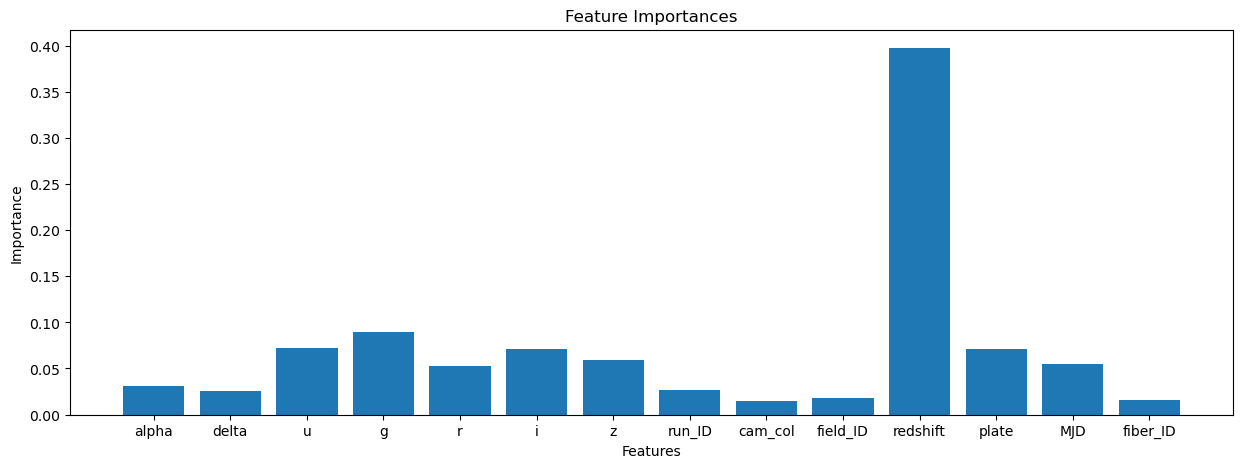

In [57]:
# Plotting a Bar Graph to compare the models
plt.figure(figsize=(15, 5))
plt.bar(X.columns, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

As expected, redshift is the most important feature, outranking any other features by several magnitudes. 

Other important features include "g", "u", "i", and "plate", which we could infer from feature subset selection as well.

### Sequential Backward Search

Let's try sequential backward search on our best classifier, decision trees.

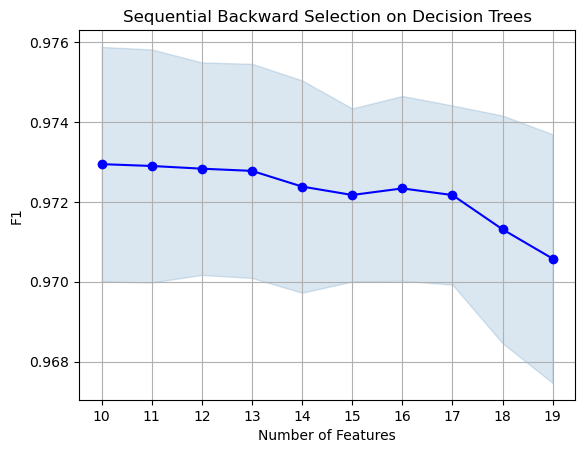

('delta', 'u', 'g', 'i', 'redshift', 'plate', 'MJD', 'cam_col_3', 'cam_col_5', 'cam_col_6')


In [58]:
dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='entropy') 
sfs_backward = SFS(dtc, k_features=10, forward=False, scoring='f1_weighted')
sfs_backward = sfs_backward.fit(X_train, y_train)
    
fig1 = plot_sfs(sfs_backward.get_metric_dict(), ylabel='F1')

plt.title(f'Sequential Backward Selection on Decision Trees')
plt.grid()
plt.show()
print(sfs_backward.k_feature_names_)
df_backward = pd.DataFrame.from_dict(sfs_backward.get_metric_dict()).T
df_backward['avg_score'] = df_backward['avg_score'].astype(float)
max_score = df_backward[df_backward['avg_score'] == df_backward['avg_score'].max()]

In [59]:
df_backward

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
19,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9654636459156306, 0.9708159576164443, 0.969...",0.970579,"(alpha, delta, u, g, r, i, z, run_ID, field_ID...",0.004004,0.003115,0.001558
18,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9660624844147461, 0.9721873365105455, 0.972...",0.971313,"(alpha, delta, u, g, r, i, run_ID, field_ID, r...",0.003666,0.002852,0.001426
17,"(1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.9680335838161688, 0.973632158679961, 0.9718...",0.972172,"(delta, u, g, r, i, run_ID, field_ID, redshift...",0.002885,0.002244,0.001122
16,"(1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 1...","[0.9680335838161688, 0.973632158679961, 0.9718...",0.972338,"(delta, u, g, r, i, run_ID, field_ID, redshift...",0.002977,0.002316,0.001158
15,"(1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 14, 15, 16, ...","[0.9681951908080674, 0.9743233509482422, 0.971...",0.972174,"(delta, u, g, r, i, run_ID, redshift, plate, M...",0.002788,0.002169,0.001085
14,"(1, 2, 3, 4, 5, 9, 10, 11, 12, 14, 15, 16, 17,...","[0.9676880424407293, 0.9722547859281736, 0.972...",0.972384,"(delta, u, g, r, i, redshift, plate, MJD, fibe...",0.00342,0.002661,0.00133
13,"(1, 2, 3, 4, 5, 9, 10, 11, 12, 14, 15, 17, 18)","[0.9679342477392302, 0.9732273614893372, 0.972...",0.972777,"(delta, u, g, r, i, redshift, plate, MJD, fibe...",0.003449,0.002683,0.001342
12,"(1, 2, 3, 5, 9, 10, 11, 12, 14, 15, 17, 18)","[0.9677017379226689, 0.9738289175888981, 0.973...",0.972833,"(delta, u, g, i, redshift, plate, MJD, fiber_I...",0.003422,0.002662,0.001331
11,"(1, 2, 3, 5, 9, 10, 11, 14, 15, 17, 18)","[0.967238398819905, 0.9755559419687782, 0.9736...",0.972900,"(delta, u, g, i, redshift, plate, MJD, cam_col...",0.003753,0.00292,0.00146
10,"(1, 2, 3, 5, 9, 10, 11, 15, 17, 18)","[0.967238398819905, 0.9755559419687782, 0.9734...",0.972946,"(delta, u, g, i, redshift, plate, MJD, cam_col...",0.003775,0.002937,0.001469


In [60]:
max_score

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
10,"(1, 2, 3, 5, 9, 10, 11, 15, 17, 18)","[0.967238398819905, 0.9755559419687782, 0.9734...",0.972946,"(delta, u, g, i, redshift, plate, MJD, cam_col...",0.003775,0.002937,0.001469


Let's compare this to forward search:

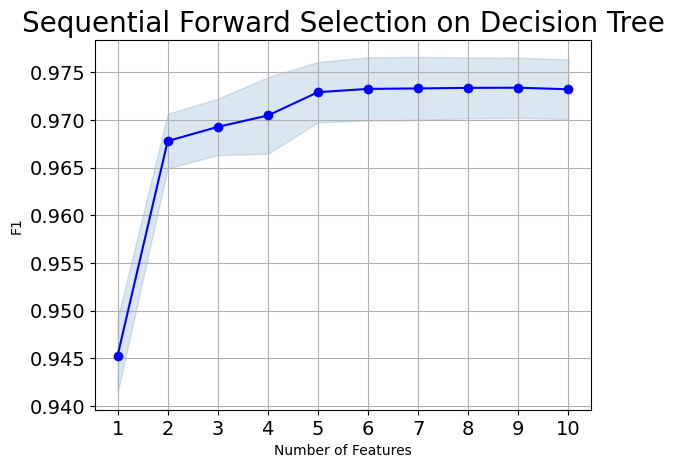

('alpha', 'u', 'g', 'i', 'redshift', 'MJD', 'cam_col_1', 'cam_col_2', 'cam_col_3', 'cam_col_4')


In [228]:
dtc = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, criterion='entropy') 
df_forward_dt, max_dt = forward_selection(dtc, "Decision Tree")

The results are quite different. Forward selection seems to have performed much better.

## Other Classifiers

Let's try other classifier algorithms now. We will compare them to the default performance of the original classifiers:

| Classifier | Parameter | Best Value | F1-Score | Original Performance |
|------------|-------------|-------------|-------------|-------------|
| KNN | Number of Neighbours (k) | 3 | 90.626% | 90.063% |
| Decision Trees     | Max Depth, Min Sample Leaf | 20, 10 | 97.062% |  96.217%        | 
| Decision Trees     | Criterion | Entropy | 97.248% |  96.217%        | 
|Linear SVM | C | 100 | 90.022% |89.584% | 
| Sigmoid | C | 0.1 |  68.05% | 66.43% |
| Poly SVM | Degree | 3 | 93.205% | 93.205% |
| RBF SVM | Gamma | 0.1 | 96.45% | 95.065% | 

### Laplacian Kernel

https://melanee-melanee.medium.com/what-a-data-scientist-should-know-about-machine-learning-kernels-4066f02d1f26

"They are used for non-linear classification problems. They map the input data into a higher-dimensional space by transforming it into a Laplacian distribution. The transformed data is then passed through a non-linear activation function to classify the data."

In [66]:
from sklearn.metrics.pairwise import laplacian_kernel

def laplacian_svm_kernel(X, y):
    return laplacian_kernel(X, y, gamma=0.1)

svc = OneVsRestClassifier(SVC(kernel=laplacian_svm_kernel))
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print('F1 score: ', round(f1_score(y_test, y_pred, average='weighted'), 5))

F1 score:  0.97159


The Laplacian kernel's performance is excellent, outperforming all classifiers on original performance. It is only beaten by Decision Trees with entropy criterion and optimal parameters. Its stellar performance is very surprising, it is certainly the best SVM kernel classifier that we have analysed so far for this dataset. This could be due to its ability to map to higher dimensional spaces and handle non-linear relationships between features. 

### Random Forest Classifier

Since decision trees were our best classifier, using random forest would be perfect to take our classification to the next level.

https://www.ibm.com/topics/random-forest

"This is a commonly-used machine learning algorithm, ..., that combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems."

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('F1 score: ', round(f1_score(y_test, y_pred, average='weighted'), 5))

F1 score:  0.97723


It produces excellent results (our best yet!), with an F1-score of 97.723%.

It is worth noting that RandomForest is an ensemble, which combines individual classifier predictions into one final output. On average, the error of an ensemble is much lower than the error of the individual classifiers, which we also see here, as the RandomForest ensemble performs better than the individual decision tree classifier. 

Ensembles give out the best possible results given the combined efforts of several classifier. Therefore, it is only natural that it performed the best here.

The results are so good, they call for a ROC AUC Curve analysis:

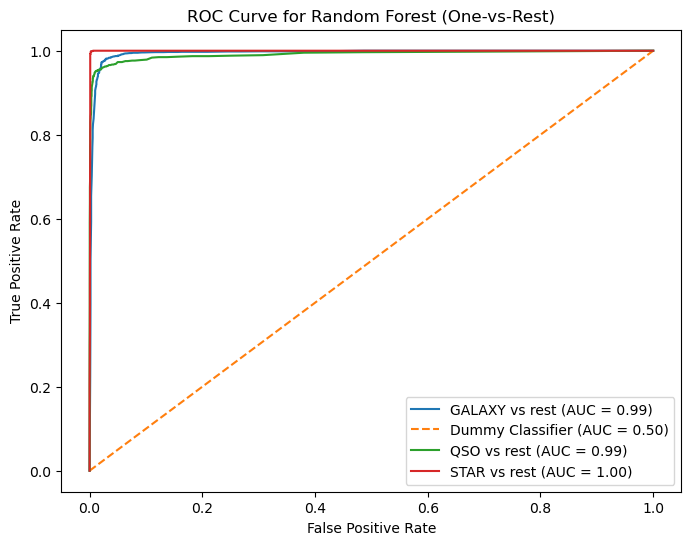

In [39]:
plot_roc_curve(RandomForestClassifier(n_estimators=150, random_state=42), 'Random Forest')

This is our best ROC AUC curve so far, with a TPR of 0.99/0.99/1.


The default criterion for RandomForest classifier is gini. Let's try running the classifier on different criteria. Namely, the other two options “entropy” and “log_loss”:

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, random_state=42, criterion='entropy')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('F1 score: ', round(f1_score(y_test, y_pred, average='weighted'), 5))

F1 score:  0.97612


In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, random_state=42, criterion='log_loss')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('F1 score: ', round(f1_score(y_test, y_pred, average='weighted'), 5))

F1 score:  0.97612


Both entropy and log_loss produce the same F1 score, which is lower than gini.

Therefore, the best classifier for this task is RandomForestClassifier with gini criterion.

### Logistic Regression with One-vs-Rest (OvR)

Let's try an algorithm we discussed in class:

In [74]:
from sklearn.linear_model import LogisticRegression

lr = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print('F1 score: ', round(f1_score(y_test, y_pred, average='weighted'), 5))

F1 score:  0.8925


Results are good, but not as good as RandomForest. Its performance is similar to Linear SVM kernel, which makes sense as logistic regression is a linear model. 

This suggests that our classification is more accurate when made by non-linear classifiers more than linear ones.

### Stochastic Gradient Descent (SGD) Classifier
And another algorithm that was mentioned in class:

In [77]:
from sklearn.linear_model import SGDClassifier

sgd = OneVsRestClassifier(SGDClassifier(loss="hinge", max_iter=100, random_state=42))
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
print('F1 score: ', round(f1_score(y_test, y_pred, average='weighted'), 5))

F1 score:  0.90298


90% is certainly not bad, but other classifiers perform better. Once again, the results are close to the Linear SVM kernel, and SGD is usually linear, so this supports our hypothesis that non-linear classifiers are better for this dataset than linear classifiers.

## Imputing missing values

Since there were no missing values in the dataset (and only 3 rows in the dataset out of 30,000 that had erroneous values), there is not much to do here. Exploration won't produce significant results.

# Further possible analysis

I have limited time to complete this project. I explored as much as time would allow, but here are other possible directions to take this project analysis further.

- Assess classifier performance after using SMOTE to balance the classes
    - https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets
- Normalise redshift (instead of standardising) and recompute everything
    - As it is the most important feature - trying different preprocessing techniques could produce different results
- Split data differently
    - Include more examples in the test or validation set
    - Try random sampling/cross validation
- Check all possible hyperparameters for models (especially high performing ones)
- Try different evaluation measures
    - Even different versions of F1, like macro or micro
- Delve deeper into ensemble classifiers, as they produced the best results
- Compute more feature subsets for SVM kernels

# Conclusion

We cleaned our dataset by creating a data quality plan. Irrelevant features were dropped, categorical features were encoded, and numerical features were standardised. An appropriate evaluation method was chosen - weighted F1-score. The dataset was stratifiably split and preprocessed accordingly to avoid peeking. We ran several classifiers on our training set, tuned our classifier parameters using the validation set, and evaluated the final models on the testing set. Feature selection methods were applied to the dataset and compared using the classifiers. ROC AUC curves were plotted to compare performance per class and per classifier. 

Further analysis was taken to uncover correlation between features. Feature extraction was applied using PCA. Another feature selection technique was used (Gini Index) and compared to previous techniques. Feature importance was calculated using ExtraTrees. Sequential backwards search was applied to the datset and compared to sequential forward search. Other classifiers were considered - Laplacian Kernels, RandomForest, Logistic Regression, and Stochastic Gradient Descent. Future analysis was considered and discussed. 

Our final best classifier was capable of classifying accurately with an F1 score of 97.723% (RandomForest), achieving a near-perfect ROC Curve of 0.99/0.99/1 AUC for each class, Galaxy, QSO, and Star, respectively.
